# **New York City Taxi Trip Duration**

## Table of Contents 
1. [Introduction](#1)  
1.1. [Introduction](#1.1)   
1.2. [Introduction](#1.2)    
2. [Preparations](#2)  
3. [Dataset Overview](#3)  
4. [Data analysis](#4)  
4.1. [Vendor Rate](#4.1)  
4.2. [Trip Duration Distribution](#4.2)  
4.3. [Rate store and forward flags](#4.3)  
4.4. [Times distribution](#4.4)   
4.5. [Passenger distribution](#4.5)  
4.6. [Taxi request map](#4.6)  
4.7. [Speed and Distance distribution](#4.7)  
4.8. [Correlation between Features&Target](#4.8)  
5. [XGBoost](#5)   
5.1 [Feature engeering](#5.1)    
5.2 [Cross-validation](#5.2)    
5.3 [Using XGBoost module](#5.3)    
5.4 [The submission](#5.4)    
5.5 [Plot Importance](#5.5)    

## 1 Introduction <a class="anchor" id="1"></a>
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.   

\\(\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }\\)

The RMSLE is calculated as     
\\(\epsilon\\) is the RMSLE value   
\\(n\\) is the total number of observations in the  data set,  
\\(p_i\\) is your prediction of trip duration, and  
\\(a_i\\) is the actual trip duration for \\(i\\).  
\\(\log\\) is the natural logarithm of \\(x\\)  

## 1.1 Dataset- New York City Taxi Duration Dataset <a class="anchor" id="1.1"></a>

Dataset is based on the 2016 NYC Yellow Cab trip record datamade available in Big Query on Google Cloud Platform. Thetraining set (contains 1458644 trip records) and the testing set(contains 625134 trip records). The attribute features of the datasetinclude:  
* id - a unique identifier for each trip  
* vendor_id - a code indicating the provider associated with the trip record  
* pickup_datetime - date and time when the meter wasengaged.  
* dropoff_datetime - date and time when the meter wasdisengaged.  
* passenger_count – driver entered value of number ofpeople travelling in the taxi.  
* pickup_latitude - the latitude where the meter wasengaged.  
* dropoff_longitude - the longitude where the meter wasdisengaged.  
* dropoff_latitude - the latitude where the meter wasdisengaged.  
* store_and_fwd_flag - This flag indicates whether thetrip record was held in vehicle memory before sendingto the vendor because the vehicle did not have aconnection to the server - Y=store and forward; N=nota store and forward trip  
* trip_duration - duration of the trip in seconds  

## 1.2 Training and testing using XGBoost <a class="anchor" id="1.2"></a>
**XGBoost (eXtreme Gradient Boosting)**  is an advancedimplementation of gradient boosting algorithm. Boosting is asequential technique which works on the principle of
**ensemble**. Itcombines a set of **weak learners** and delivers improved predictionaccuracy. At any instant t, the model outcomes are weighed basedon the outcomes of previous instant t-1. The outcomes predictedcorrectly are given a lower weight and the ones miss-classified areweighted higher. This technique is followed for a classificationproblem while a similar technique is used for regression.

## 2 Preparations <a class="anchor" id="2"></a>

In [1]:
# import packages
import os
import joblib
import numpy as np
import pandas as pd
import warnings

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns

import calendar

import plotly.express as px
from colorcet import kbc, bmy, fire
import datashader.transfer_functions as tf
import datashader as ds
import plotly.express as px

from geopy.distance import geodesic
import swifter

from sklearn.model_selection import KFold
import xgboost as xgb


In [2]:
# setting up options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime']) # привели к формату datetime
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train_df_copy = train.copy()
test_df_copy = test.copy()

## 3 Dataset Overview <a class="anchor" id="3"></a>

In [ ]:
train.head(5)

## 4 Data analysis <a class="anchor" id="4"></a>
### 4.1 Vendor Rate <a class="anchor" id="4.1"></a>

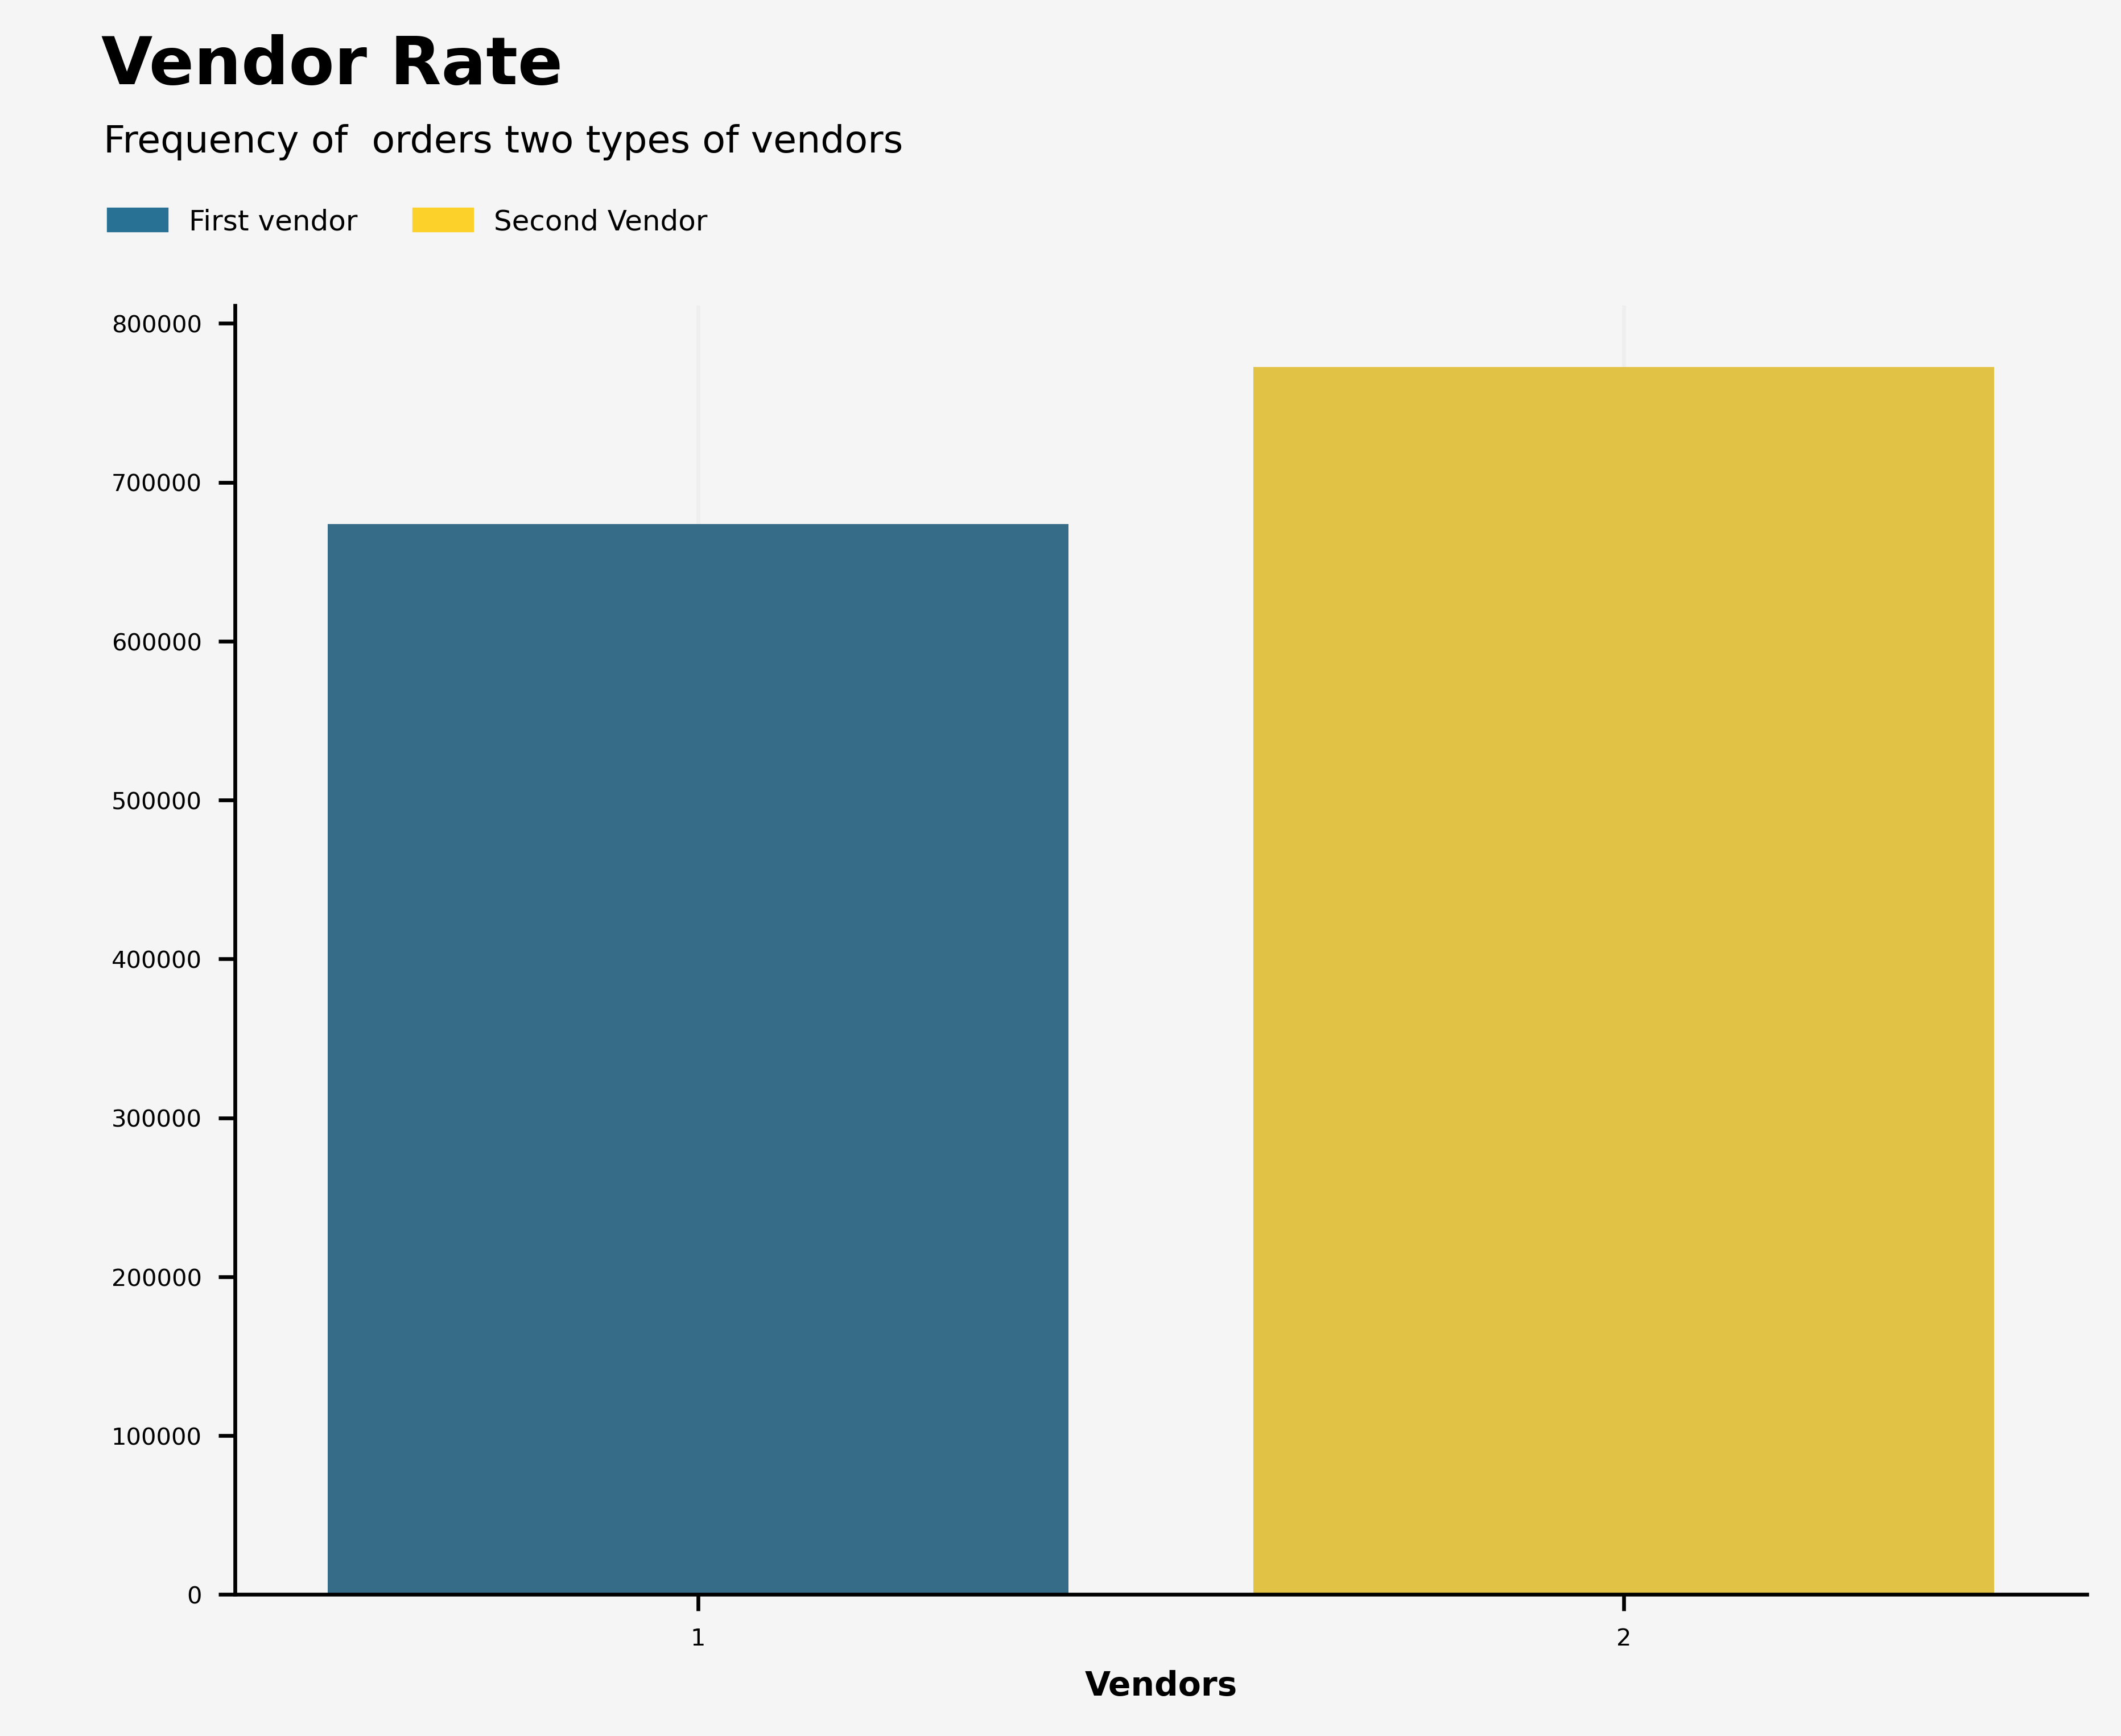

In [3]:
targets = ["vendor_id", "trip_duration"]
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(7, 5), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.6, hspace=0.8)

background_color = "#f6f5f5"
color_map = ['#287094', '#fcd12a']
sns.set_palette(sns.color_palette(color_map))

train = train[(train['trip_duration'] < 3600)] 

ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0_sns = sns.countplot(ax=ax0, x='vendor_id', data = train, zorder=2)
ax0_sns.grid(which='major', axis='x', zorder=2, color='#EEEEEE')
ax0_sns.tick_params(labelsize=5)
ax0_sns.set_xlabel('Vendors', fontsize=7, weight='bold')
ax0_sns.set_ylabel('')

fig.text(0.069, 1.01, 'Vendor Rate', fontsize=14, fontweight='bold')
fig.text(0.07, 0.97, 'Frequency of  orders two types of vendors', fontsize=8)
yellow = mpatches.Patch(color='#287094')
blue = mpatches.Patch(color='#fcd12a')
fig.legend(handles = [yellow, blue], labels = ['First vendor', 'Second Vendor'], ncol=2, facecolor=background_color, edgecolor=background_color, fontsize=6, loc='upper left', bbox_to_anchor=(0.035, 0.91))

### 4.2 Trip Duration Distribution <a class="anchor" id="4.2"></a>

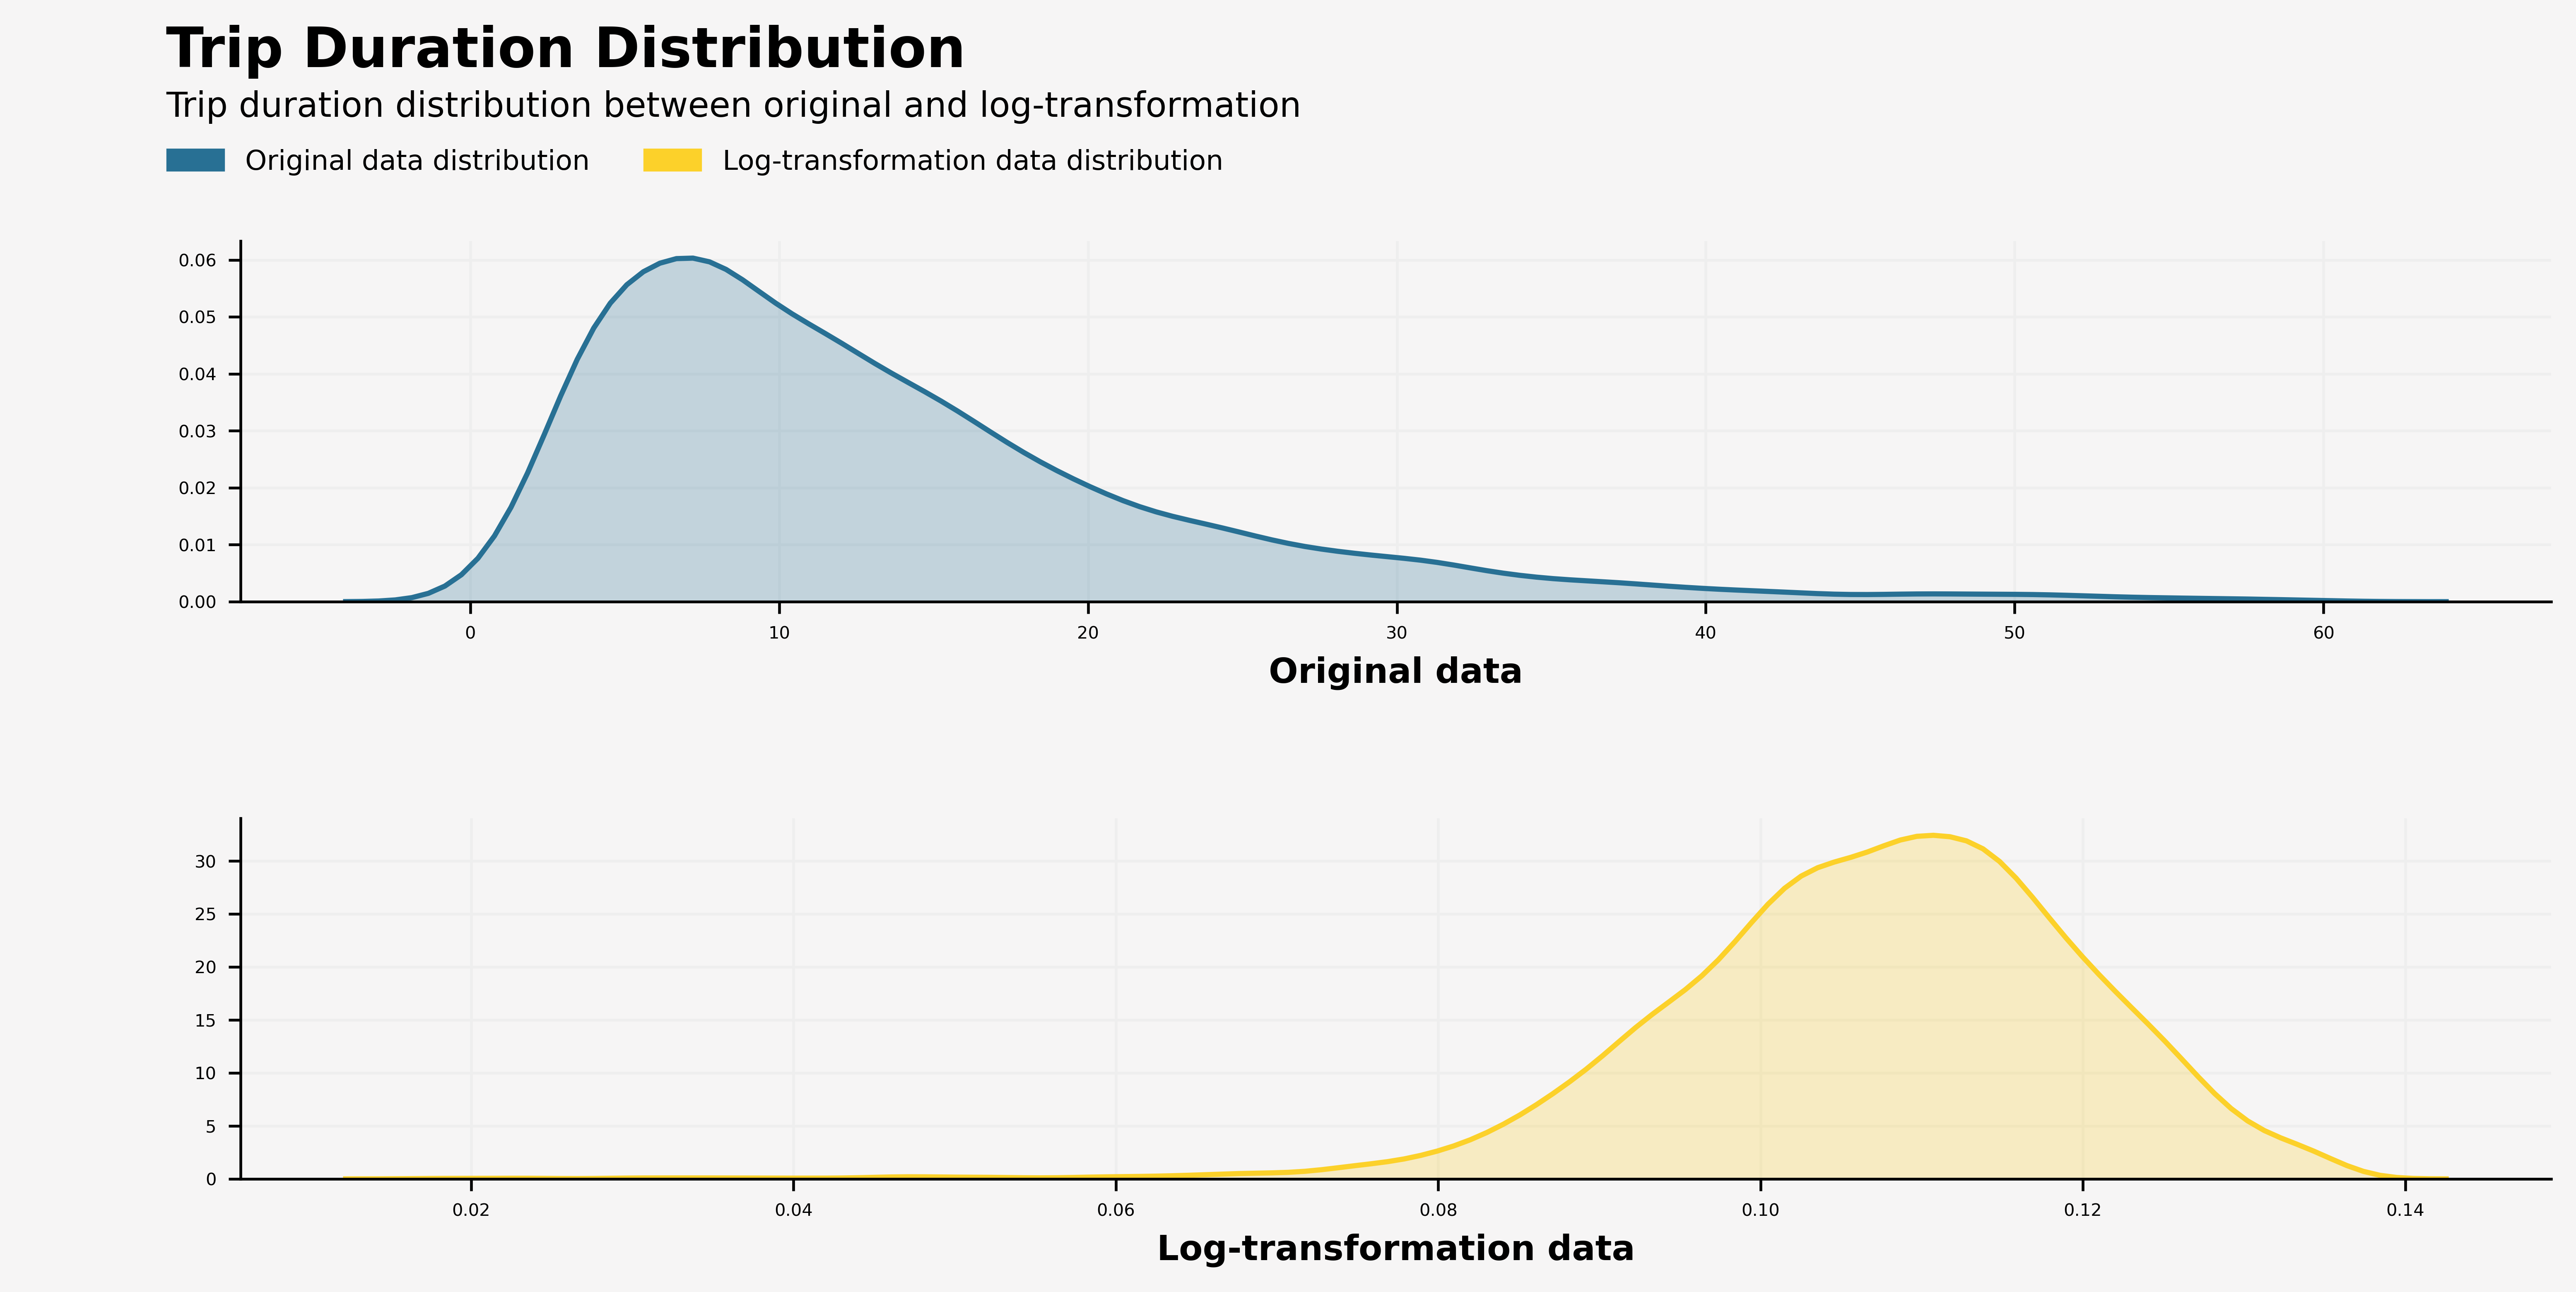

In [4]:

trip_duration_hist = train['trip_duration'].sample(n=10000, replace=True, random_state=123) / 60
train['trip_duration_log'] = np.log(train['trip_duration'].values)
trip_duration_hist_log = train['trip_duration_log'].sample(n=10000, replace=True, random_state=123) / 60
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(12, 5), facecolor = '#f6f5f5')
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.6, hspace=0.6)

background_color = "#f6f5f5"
color_map = ['#287094', '#fcd12a']
sns.set_palette(sns.color_palette(color_map))

ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0_sns = sns.kdeplot(ax=ax0, data = trip_duration_hist, zorder=2, shade=True)
ax0_sns.set_xlabel('Original data', fontsize=10, weight='bold')
ax0_sns.set_ylabel('')
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax0_sns.tick_params(labelsize=5)
ax0_sns.get_legend().remove()

color_map = ['#fcd12a']
sns.set_palette(sns.color_palette(color_map))
ax1 = fig.add_subplot(gs[1, 0])
for s in ["right", "top"]:
    ax1.spines[s].set_visible(False)
ax1.set_facecolor(background_color)
ax1_sns = sns.kdeplot(ax=ax1, data = trip_duration_hist_log, zorder=2, shade=True)
ax1_sns.set_xlabel('Log-transformation data', fontsize=10, weight='bold')
ax1_sns.set_ylabel('')
ax1_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax1_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax1_sns.tick_params(labelsize=5)
ax1_sns.get_legend().remove()

fig.text(0.1, 1.02, 'Trip Duration Distribution', fontsize=16, fontweight='bold')
fig.text(0.1, 0.98, 'Trip duration distribution between original and log-transformation', fontsize=10)

blue = mpatches.Patch(color='#287094')
yellow = mpatches.Patch(color='#fcd12a')
fig.legend(handles = [blue, yellow], labels =  ['Original data distribution', 'Log-transformation data distribution'], ncol=2, facecolor=background_color, edgecolor=background_color, fontsize=8, loc='upper left', bbox_to_anchor=(0.048, 0.94))

### 4.3 Rate store and forward flags <a class="anchor" id="4.3"></a>

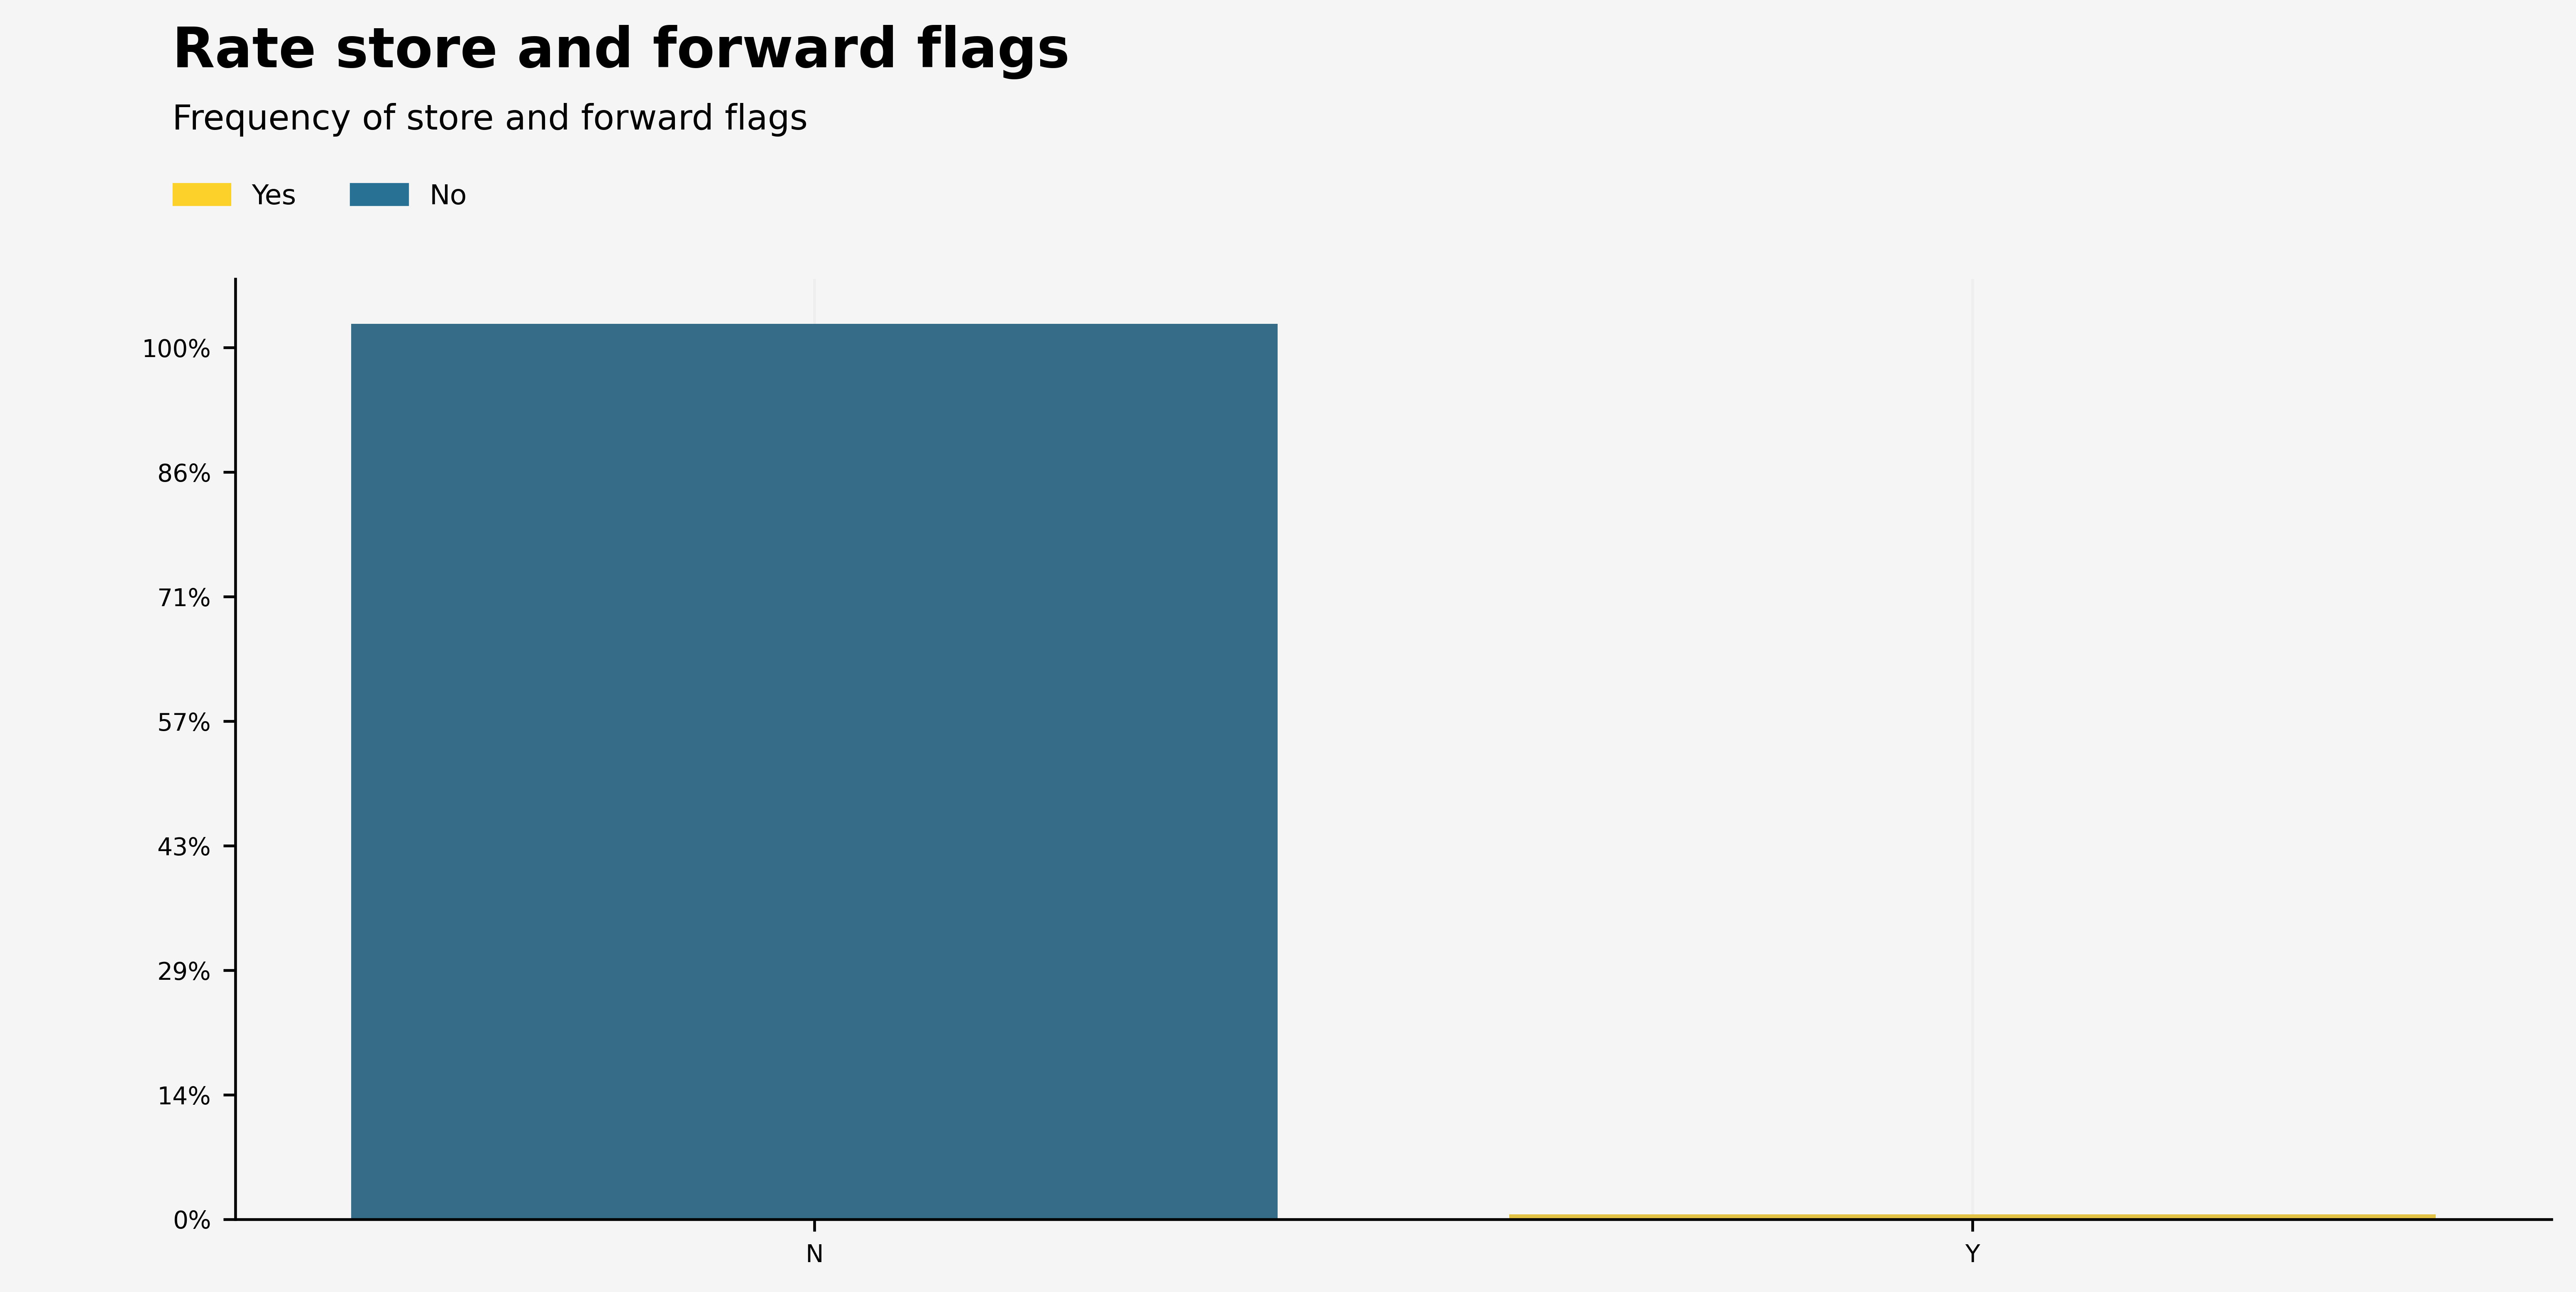

In [5]:
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(12, 5), facecolor = '#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.6, hspace=0.8)

background_color = "#f6f5f5"
color_map = ['#287094', '#fcd12a']
sns.set_palette(sns.color_palette(color_map))

ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0_sns = sns.countplot(ax=ax0, x='store_and_fwd_flag', data = train, zorder=2)
ax0_sns.grid(which='major', axis='x', zorder=2, color='#EEEEEE')
ax0_sns.tick_params(labelsize=7)
ax0_sns.set_xlabel('', fontsize=9, weight='bold')
ax0_sns.set_ylabel('')
ax0.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1400000))

fig.text(0.104, 1.05, 'Rate store and forward flags', fontsize=16, fontweight='bold')
fig.text(0.104, 1, 'Frequency of store and forward flags', fontsize=10)

yellow = mpatches.Patch(color='#287094')
blue = mpatches.Patch(color='#fcd12a')
fig.legend(handles = [blue, yellow], labels = ['Yes', 'No'], ncol=2, facecolor=background_color, edgecolor=background_color, fontsize=8, loc='upper left', bbox_to_anchor=(0.05, 0.91))

### 4.4 Times distribution  <a class="anchor" id="4.4"></a>

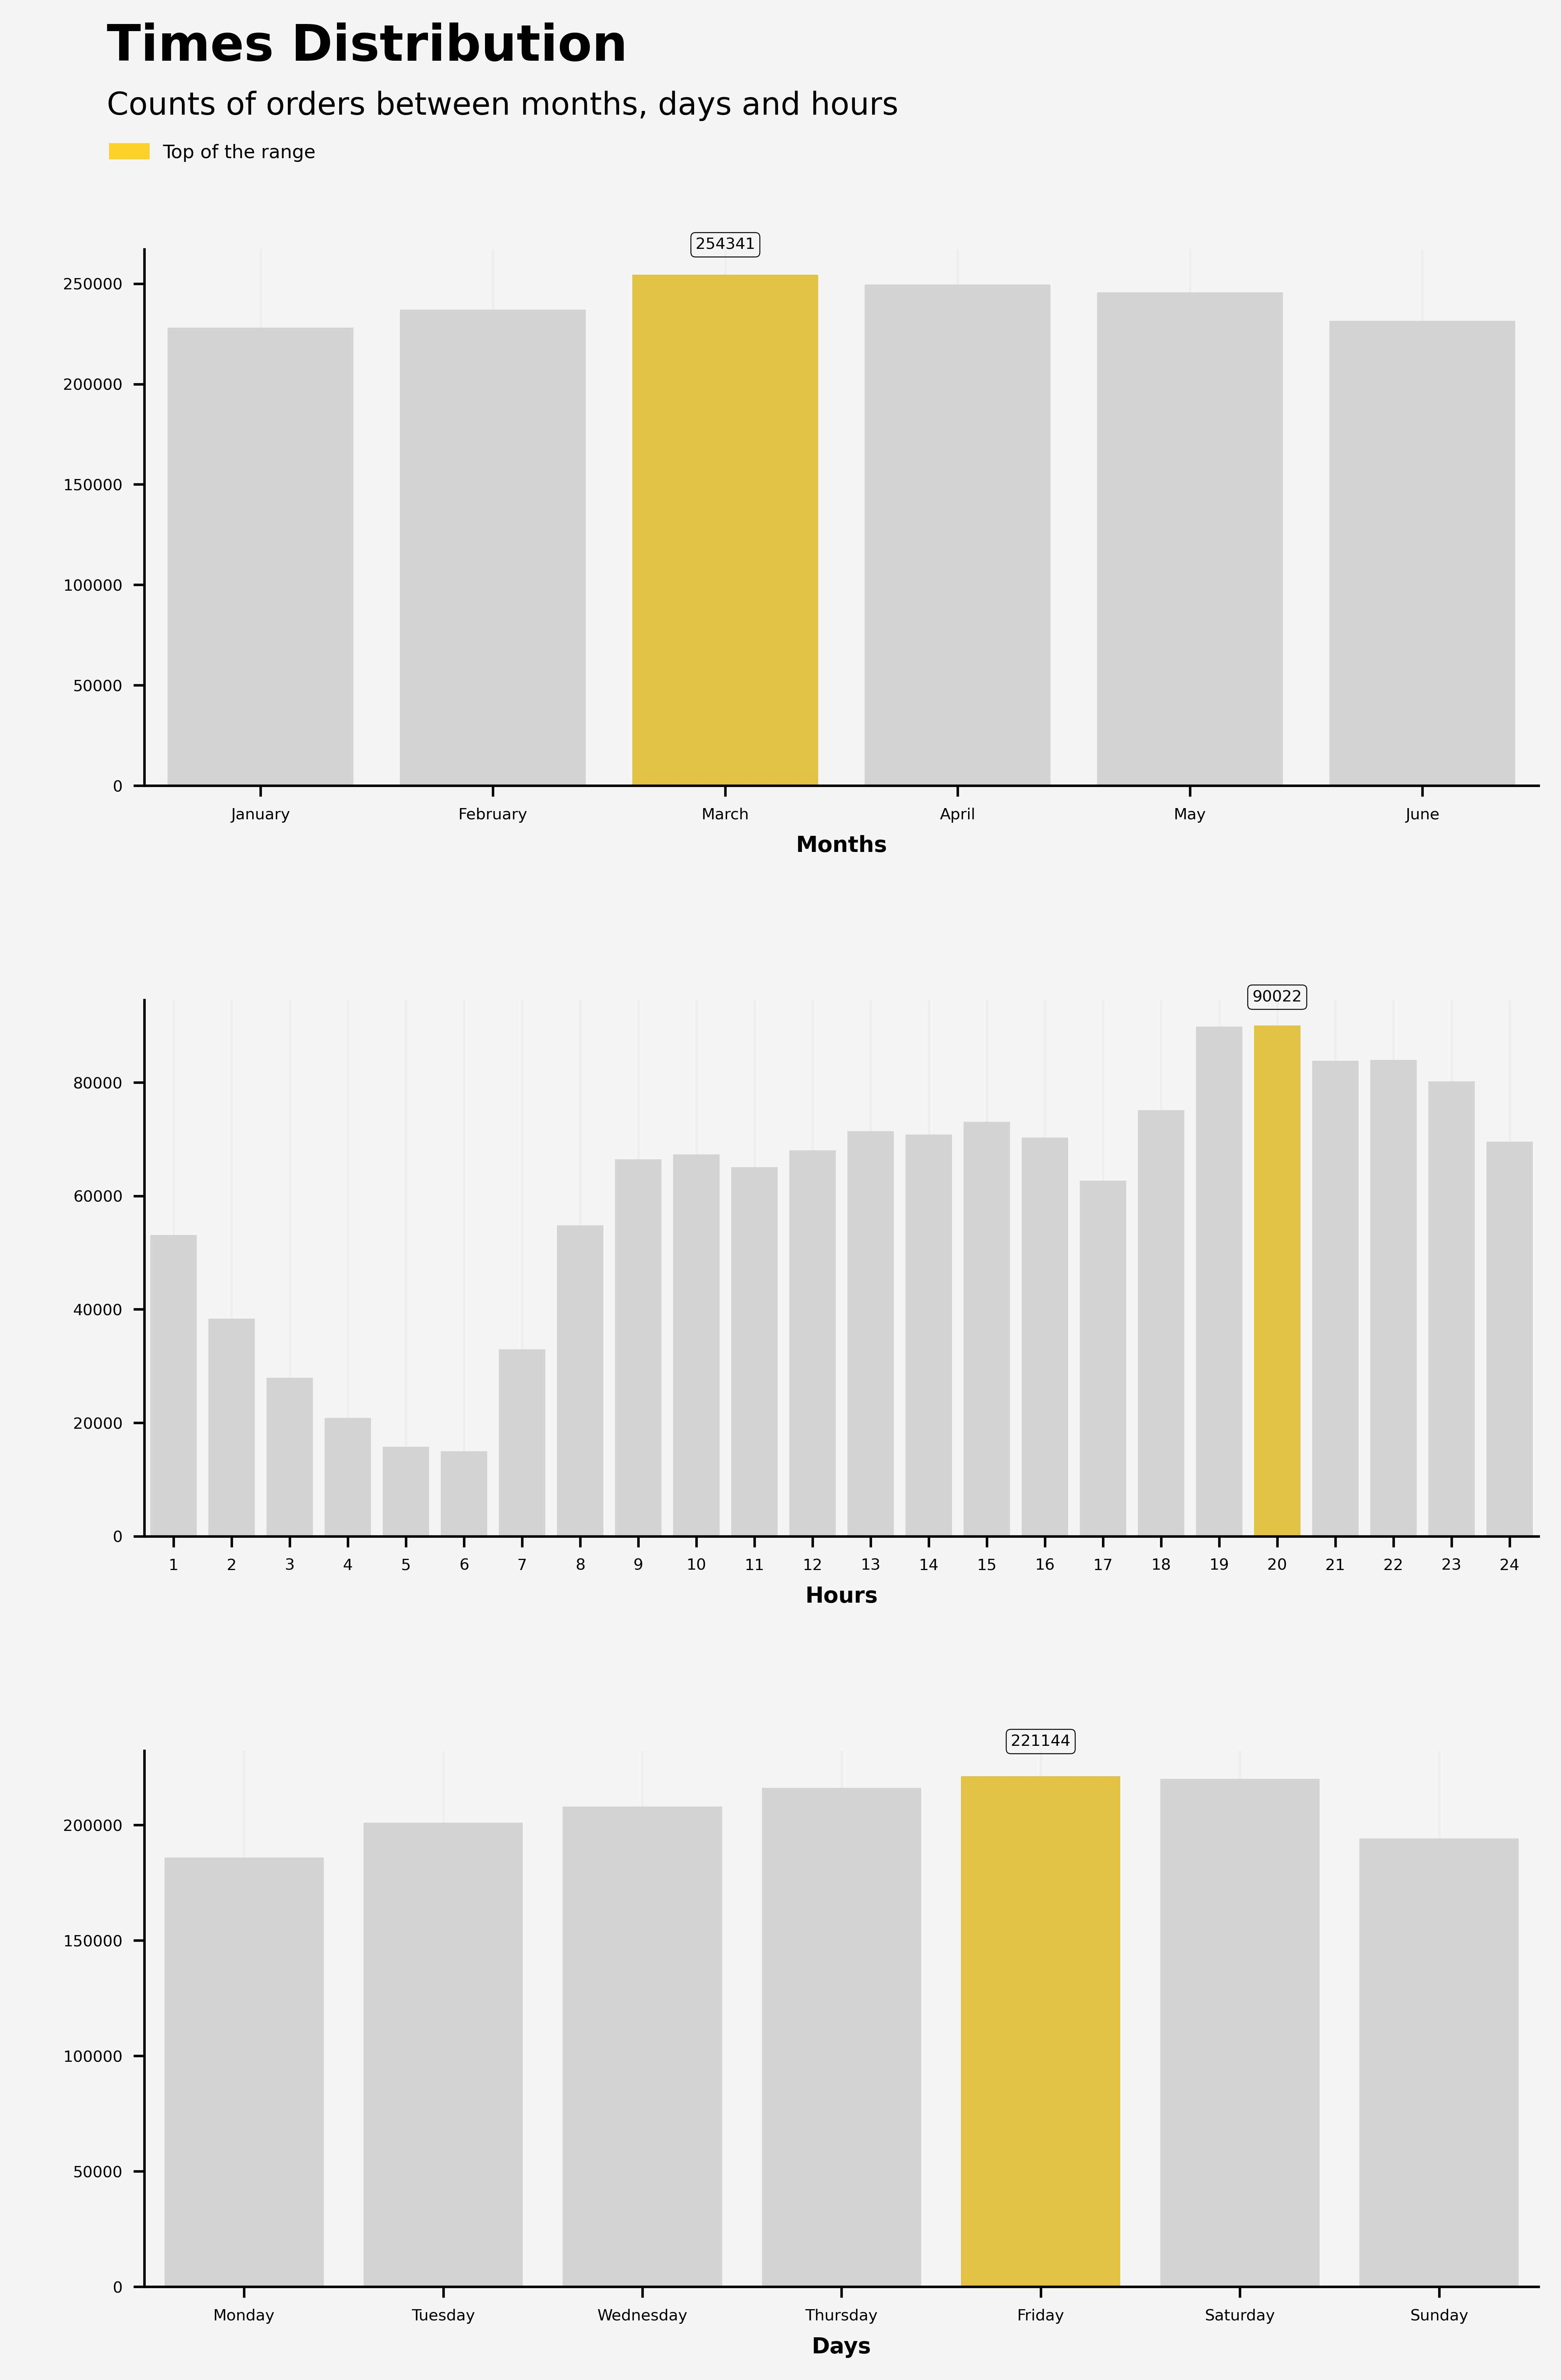

In [6]:
def to_split_time(df):
    df['pickup_month'] = df.pickup_datetime.apply(lambda M : M.month)
    df['pickup_date'] = df.pickup_datetime.apply(lambda D : D.day)
    df['pickup_hour'] = df.pickup_datetime.apply(lambda h : h.hour)
    df['pickup_minute'] = df.pickup_datetime.apply(lambda m : m.minute)
    df['pickup_day'] = df.pickup_datetime.apply(lambda d : d.weekday())
    
to_split_time(train)
to_split_time(test)

names_month = list(dict(enumerate(calendar.month_name)).values())

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(8, 12), facecolor = '#f6f5f5')
gs = fig.add_gridspec(3, 1)
gs.update(wspace=0.6, hspace=0.4)

background_color = "#f6f5f5"
color_map_1 = ['#287094', '#fcd12a']

ax0 = fig.add_subplot(gs[0, 0])
color_map_0 = ['lightgray' for _ in range(6)]
color_map_0[2] = '#fcd12a'
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
sns.set_palette(sns.color_palette(color_map_0))
ax0.set_facecolor(background_color)
ax0_sns = sns.barplot(ax = ax0, y = train['pickup_month'].value_counts().sort_index().values, x = train['pickup_month'].value_counts().sort_index().index, zorder = 2)
ax0_sns.grid(which='major', axis='x', zorder=2, color='#EEEEEE')
ax0_sns.tick_params(labelsize=5)
ax0_sns.set_xlabel('Months', fontsize=7, weight='bold')
ax0_sns.set_ylabel('')
ax0_sns.set_xticklabels(names_month[1:], rotation=0);
p = ax0.patches[2]
percentage = f'{p.get_height():.0f}'
x_p = p.get_x() + p.get_width() / 2
y_p = p.get_height() + 15000
ax0.text(x_p, y_p, percentage, ha='center', va='center', fontsize=5,
bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))


ax1 = fig.add_subplot(gs[1, 0])
color_map_1 = ['lightgray' for _ in range(24)]
color_map_1[19] = '#fcd12a'
for s in ["right", "top"]:
    ax1.spines[s].set_visible(False)
sns.set_palette(sns.color_palette(color_map_1))
ax1.set_facecolor(background_color)
ax1_sns = sns.barplot(ax = ax1, y = train['pickup_hour'].value_counts().sort_index().values, x = train['pickup_hour'].value_counts().sort_index().index +1, zorder = 2)
ax1_sns.grid(which='major', axis='x', zorder=2, color='#EEEEEE')
ax1_sns.tick_params(labelsize=5)
ax1_sns.set_xlabel('Hours', fontsize=7, weight='bold')
ax1_sns.set_ylabel('')
p = ax1.patches[19]
percentage = f'{p.get_height():.0f}'
x_p = p.get_x() + p.get_width() / 2
y_p = p.get_height() + 5000
ax1.text(x_p, y_p, percentage, ha='center', va='center', fontsize=5,
bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

ax2 = fig.add_subplot(gs[2, 0])
color_map_2 = ['lightgray' for _ in range(7)]
color_map_2[4] = '#fcd12a'
for s in ["right", "top"]:
    ax2.spines[s].set_visible(False)
sns.set_palette(sns.color_palette(color_map_2))
ax2.set_facecolor(background_color)
ax2_sns = sns.barplot(ax = ax2, y = train['pickup_day'].value_counts().sort_index().values, x = train['pickup_day'].value_counts().sort_index().index +1, zorder = 2)
ax2_sns.grid(which='major', axis='x', zorder=2, color='#EEEEEE')
ax2_sns.tick_params(labelsize=5)
ax2_sns.set_xlabel('Days', fontsize=7, weight='bold')
ax2_sns.set_ylabel('')
ax2_sns.set_xticklabels(list(dict(enumerate(calendar.day_name)).values()), rotation=0);
p = ax2.patches[4]
percentage = f'{p.get_height():.0f}'
x_p = p.get_x() + p.get_width() / 2
y_p = p.get_height() + 15000
ax2.text(x_p, y_p, percentage, ha='center', va='center', fontsize=5,
bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

fig.text(0.104, 0.95, 'Times Distribution', fontsize=16, fontweight='bold')
fig.text(0.104, 0.93, 'Counts of orders between months, days and hours', fontsize=10)

blue = mpatches.Patch(color='#fcd12a')
fig.legend(handles = [blue], labels = ['Top of the range'], ncol=2, facecolor=background_color, edgecolor=background_color, fontsize=6, loc='upper left', bbox_to_anchor=(0.052, 0.835))

### 4.5 Passenger distribution  <a class="anchor" id="4.5"></a>

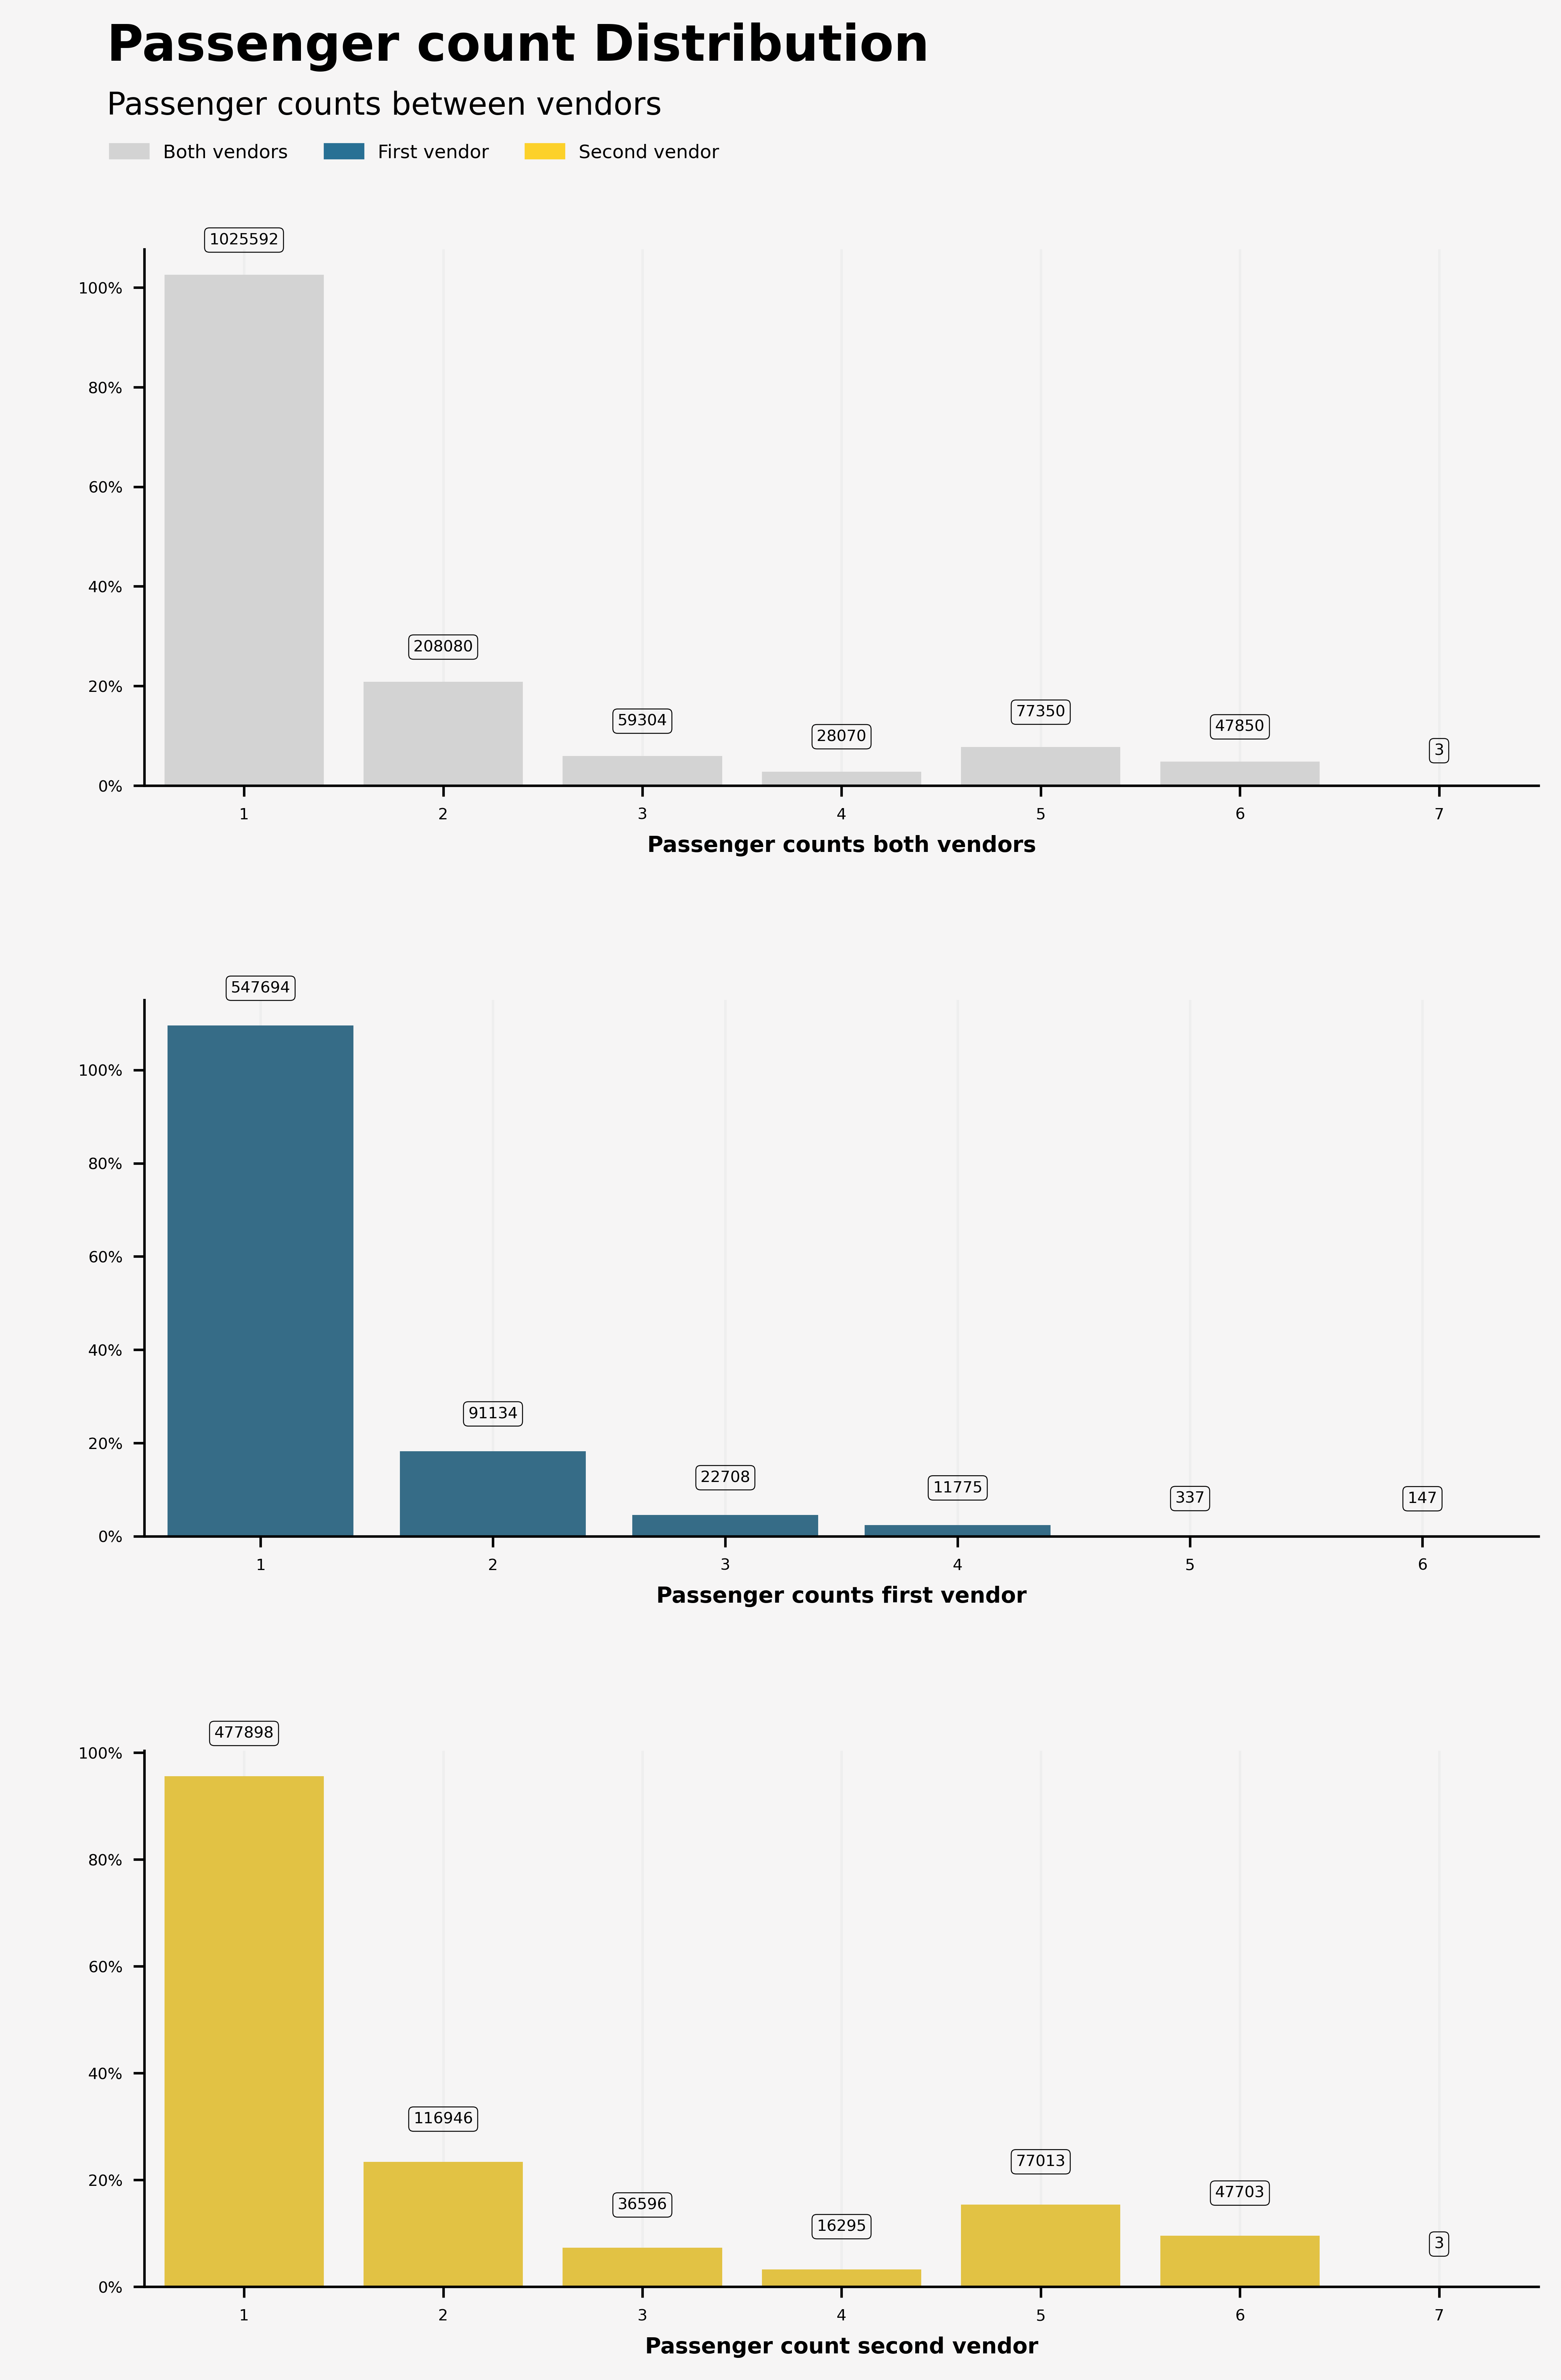

In [7]:
train = train[(train['passenger_count'] < 8) & (train['passenger_count'] > 0)]

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(8, 12), facecolor = '#f6f5f5')
gs = fig.add_gridspec(3, 1)
gs.update(wspace=0.6, hspace=0.4)

background_color = "#f6f5f5"
color_map_1 = ['#287094', '#fcd12a']

ax0 = fig.add_subplot(gs[0, 0])
color_map_0 = ['lightgray' for _ in range(7)]
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
sns.set_palette(sns.color_palette(color_map_0))
ax0.set_facecolor(background_color)
ax0_sns = sns.countplot(ax = ax0, x='passenger_count', data=train, zorder = 2)
ax0_sns.grid(which='major', axis='x', zorder=2, color='#EEEEEE')
ax0_sns.tick_params(labelsize=5)
ax0_sns.set_xlabel('Passenger counts both vendors', fontsize=7, weight='bold')
ax0_sns.set_ylabel('')
ax0.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1000000))
for p in ax0.patches:
    percentage = f'{p.get_height():.0f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 70000
    ax0.text(x, y, percentage, ha='center', va='center', fontsize=5,
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

ax1 = fig.add_subplot(gs[1, 0])
color_map_1 = ['#287094' for _ in range(6)]
for s in ["right", "top"]:
    ax1.spines[s].set_visible(False)
sns.set_palette(sns.color_palette(color_map_1))
ax1.set_facecolor(background_color)
ax1_sns = sns.countplot(x='passenger_count', data=train[train['vendor_id'] == 1], zorder = 2)
ax1_sns.grid(which='major', axis='x', zorder=2, color='#EEEEEE')
ax1_sns.tick_params(labelsize=5)
ax1_sns.set_xlabel('Passenger counts first vendor', fontsize=7, weight='bold')
ax1_sns.set_ylabel('')
ax1.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(500000))
for p in ax1.patches:
    percentage = f'{p.get_height():.0f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 40000
    ax1.text(x, y, percentage, ha='center', va='center', fontsize=5,
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

ax2 = fig.add_subplot(gs[2, 0])
color_map_2 = ['#fcd12a' for _ in range(7)]
for s in ["right", "top"]:
    ax2.spines[s].set_visible(False)
sns.set_palette(sns.color_palette(color_map_2))
ax2.set_facecolor(background_color)
ax2_sns = sns.countplot(x='passenger_count', data=train[train['vendor_id'] == 2], zorder = 2)
ax2_sns.grid(which='major', axis='x', zorder=2, color='#EEEEEE')
ax2_sns.tick_params(labelsize=5)
ax2_sns.set_xlabel('Passenger count second vendor', fontsize=7, weight='bold')
ax2_sns.set_ylabel('')
ax2.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(500000))
for p in ax2.patches:
    percentage = f'{p.get_height():.0f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 40000
    ax2.text(x, y, percentage, ha='center', va='center', fontsize=5,
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

fig.text(0.104, 0.95, 'Passenger count Distribution', fontsize=16, fontweight='bold')
fig.text(0.104, 0.93, 'Passenger counts between vendors', fontsize=10)

blue = mpatches.Patch(color='#287094')
gray = mpatches.Patch(color='lightgray')
yellow = mpatches.Patch(color='#fcd12a')
fig.legend(handles = [gray, blue, yellow], labels = ['Both vendors', 'First vendor', 'Second vendor'], ncol=3, facecolor=background_color, edgecolor=background_color, fontsize=6, loc='upper left', bbox_to_anchor=(0.052, 0.835))

### 4.6 Taxi request map  <a class="anchor" id="4.6"></a>


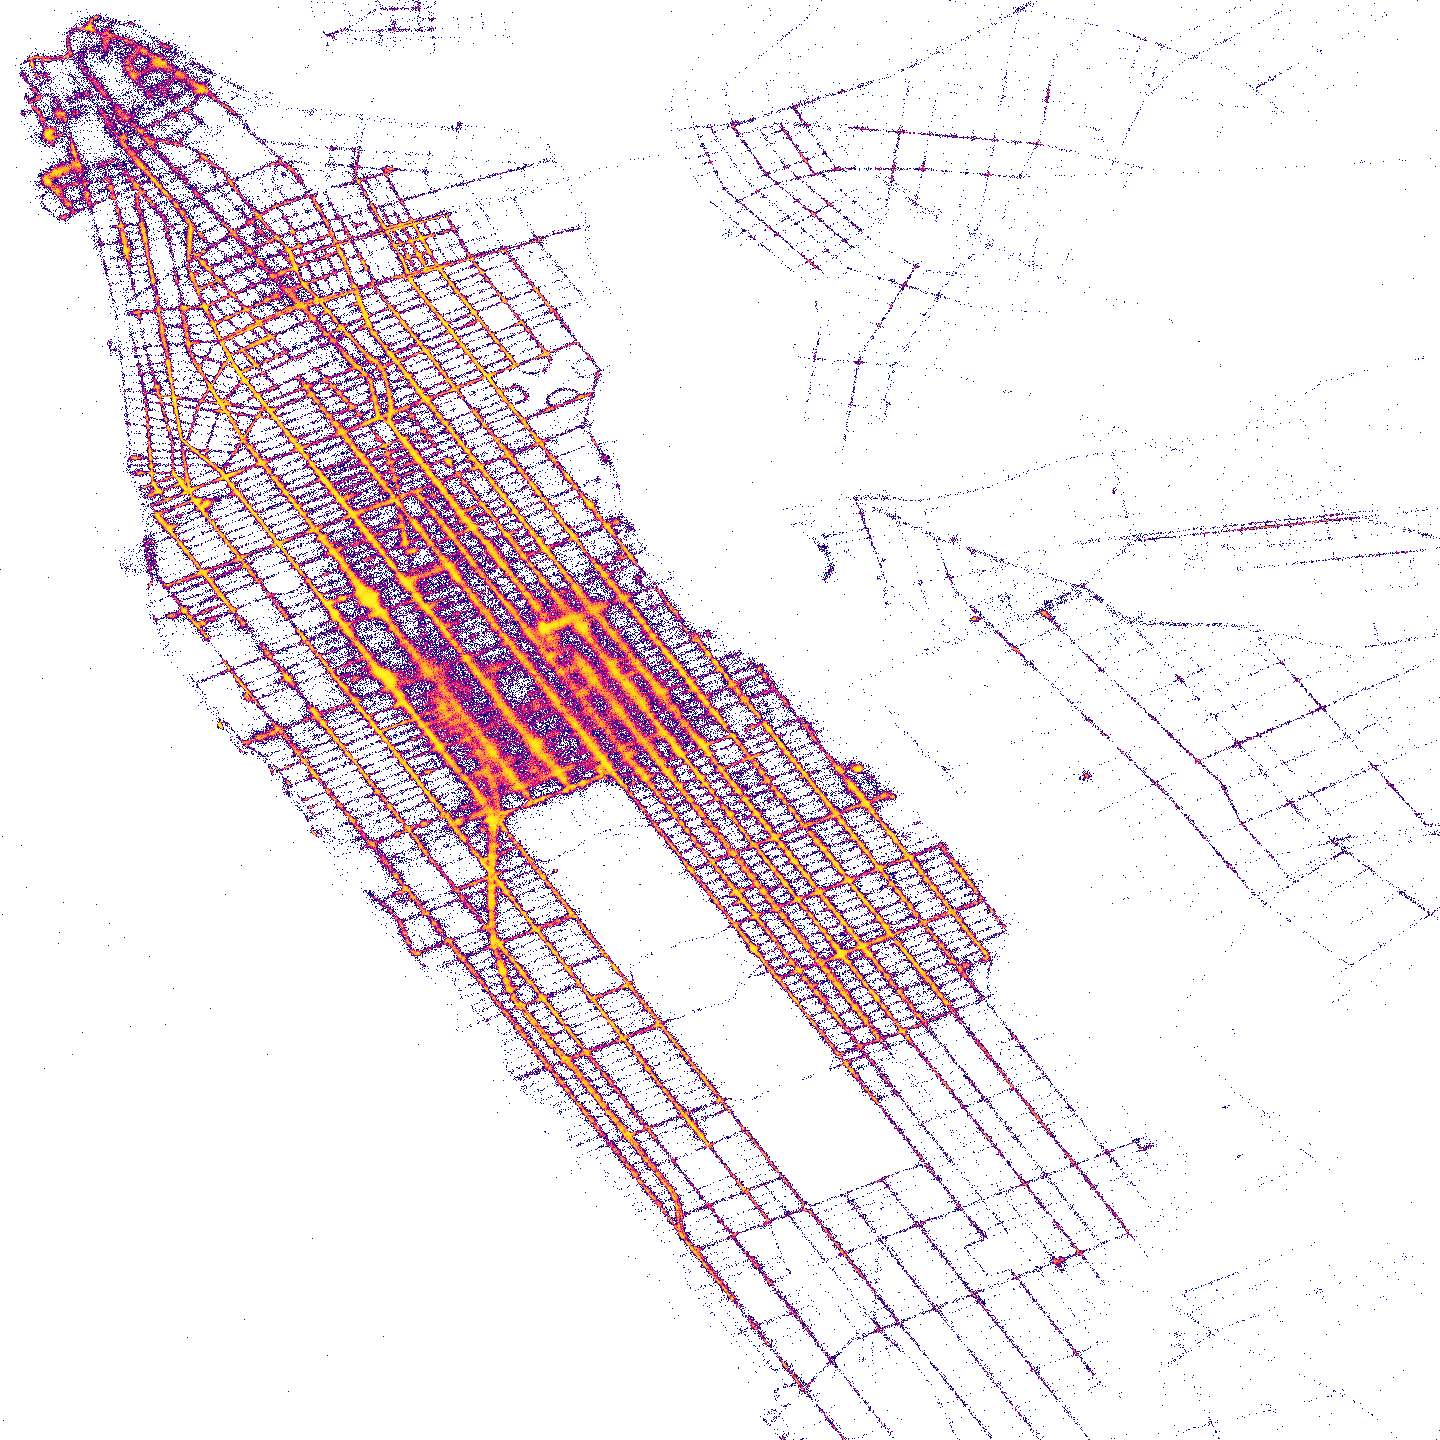


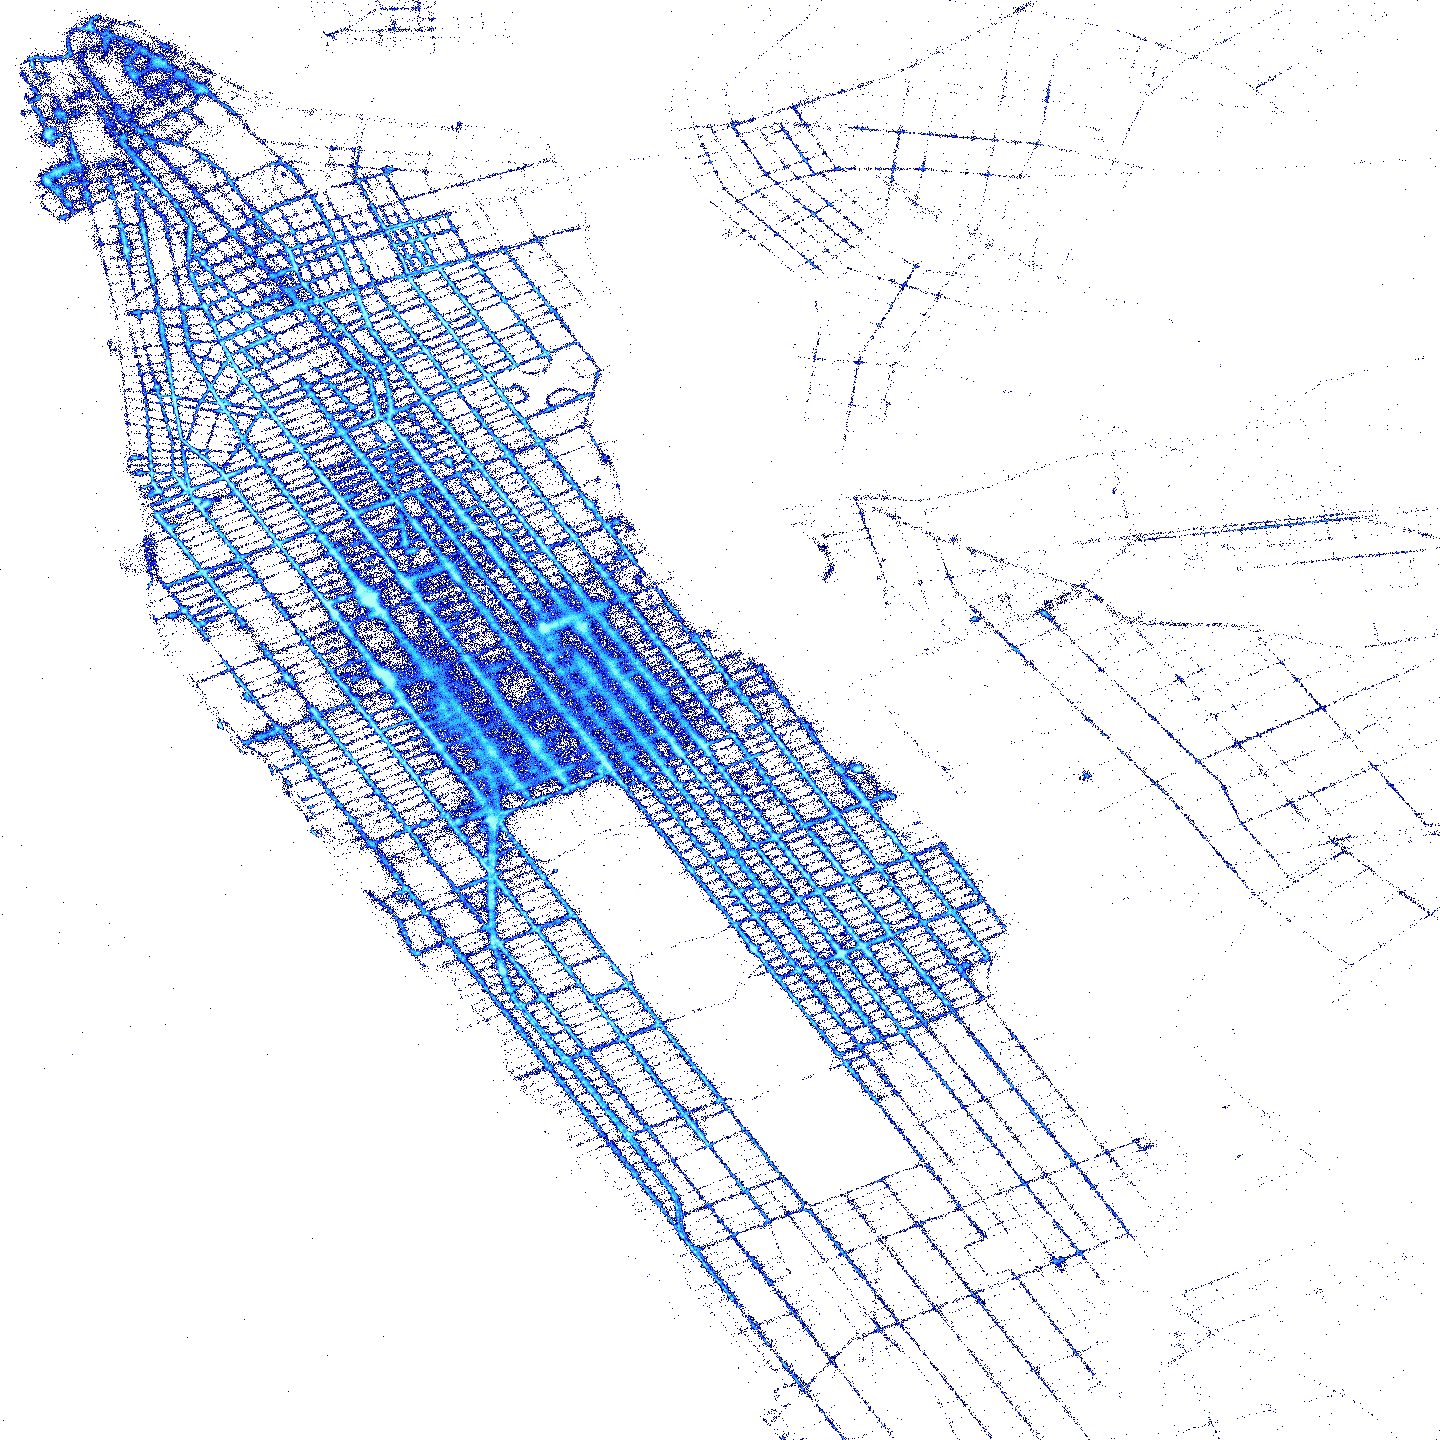

<Figure size 12000x12000 with 0 Axes>

<Figure size 12000x12000 with 0 Axes>

In [8]:
pick_up_df = train[['pickup_datetime', 'pickup_longitude', 'pickup_latitude']]
drop_off_df = train[['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude']]
pick_up_df.columns = ['Date/Time','Lon','Lat']
drop_off_df.columns = ['Date/Time','Lon','Lat']
def create_map(df, color):
    plt.figure(figsize=(20, 20))
    dff = df.query('Lat < 40.82').query('Lat > 40.70').query('Lon > -74.02').query('Lon < -73.91')

    cvs = ds.Canvas(plot_width=1440, plot_height=1440);
    agg = cvs.points(dff, x='Lon', y='Lat')
    coords_lat, coords_lon = agg.coords['Lat'].values, agg.coords['Lon'].values
    coordinates = [[coords_lon[0], coords_lat[0]],
                   [coords_lon[-1], coords_lat[0]],
                   [coords_lon[-1], coords_lat[-1]],
                   [coords_lon[0], coords_lat[-1]]]

    img = tf.shade(agg, cmap=color, how='eq_hist')[::-1].to_pil()
    fig = px.scatter_mapbox(dff[:1], lat='Lat', lon='Lon', zoom=11);
    fig.update_layout(mapbox_style="carto-darkmatter",
                     mapbox_layers = [
                    {
                        "sourcetype": "image",
                        "source": img,
                        "coordinates": coordinates
                    }]
    )
    fig.show()
create_map(pick_up_df, bmy);
create_map(pick_up_df, kbc);

In [9]:
def get_distance(source_lat, source_long, dest_lat, dest_long):
    # Returns the distance in Miles between the source and the destination.
    
    distance = geodesic((source_lat, source_long), 
                        (dest_lat, dest_long)).miles
    return distance

train['distance'] = train.swifter.apply(lambda x: get_distance(x.pickup_latitude, x.pickup_longitude,x.dropoff_latitude, x.dropoff_longitude), axis=1)
test['distance'] = test.swifter.apply(lambda x: get_distance(x.pickup_latitude, x.pickup_longitude,x.dropoff_latitude, x.dropoff_longitude), axis=1)
train['speed'] = train['distance'] / (train['trip_duration'] /3600)

train = train[(train.pickup_longitude > -100)]
train = train[(train.pickup_latitude < 50)]
train = train[(train.dropoff_longitude < -70) & (train.dropoff_longitude > -80)]
train = train[(train.dropoff_latitude < 50)]
train = train[(train.distance < 200)]
train = train[(train.speed < 30)]

### 4.7 Speed and Distance distribution  <a class="anchor" id="4.7"></a>

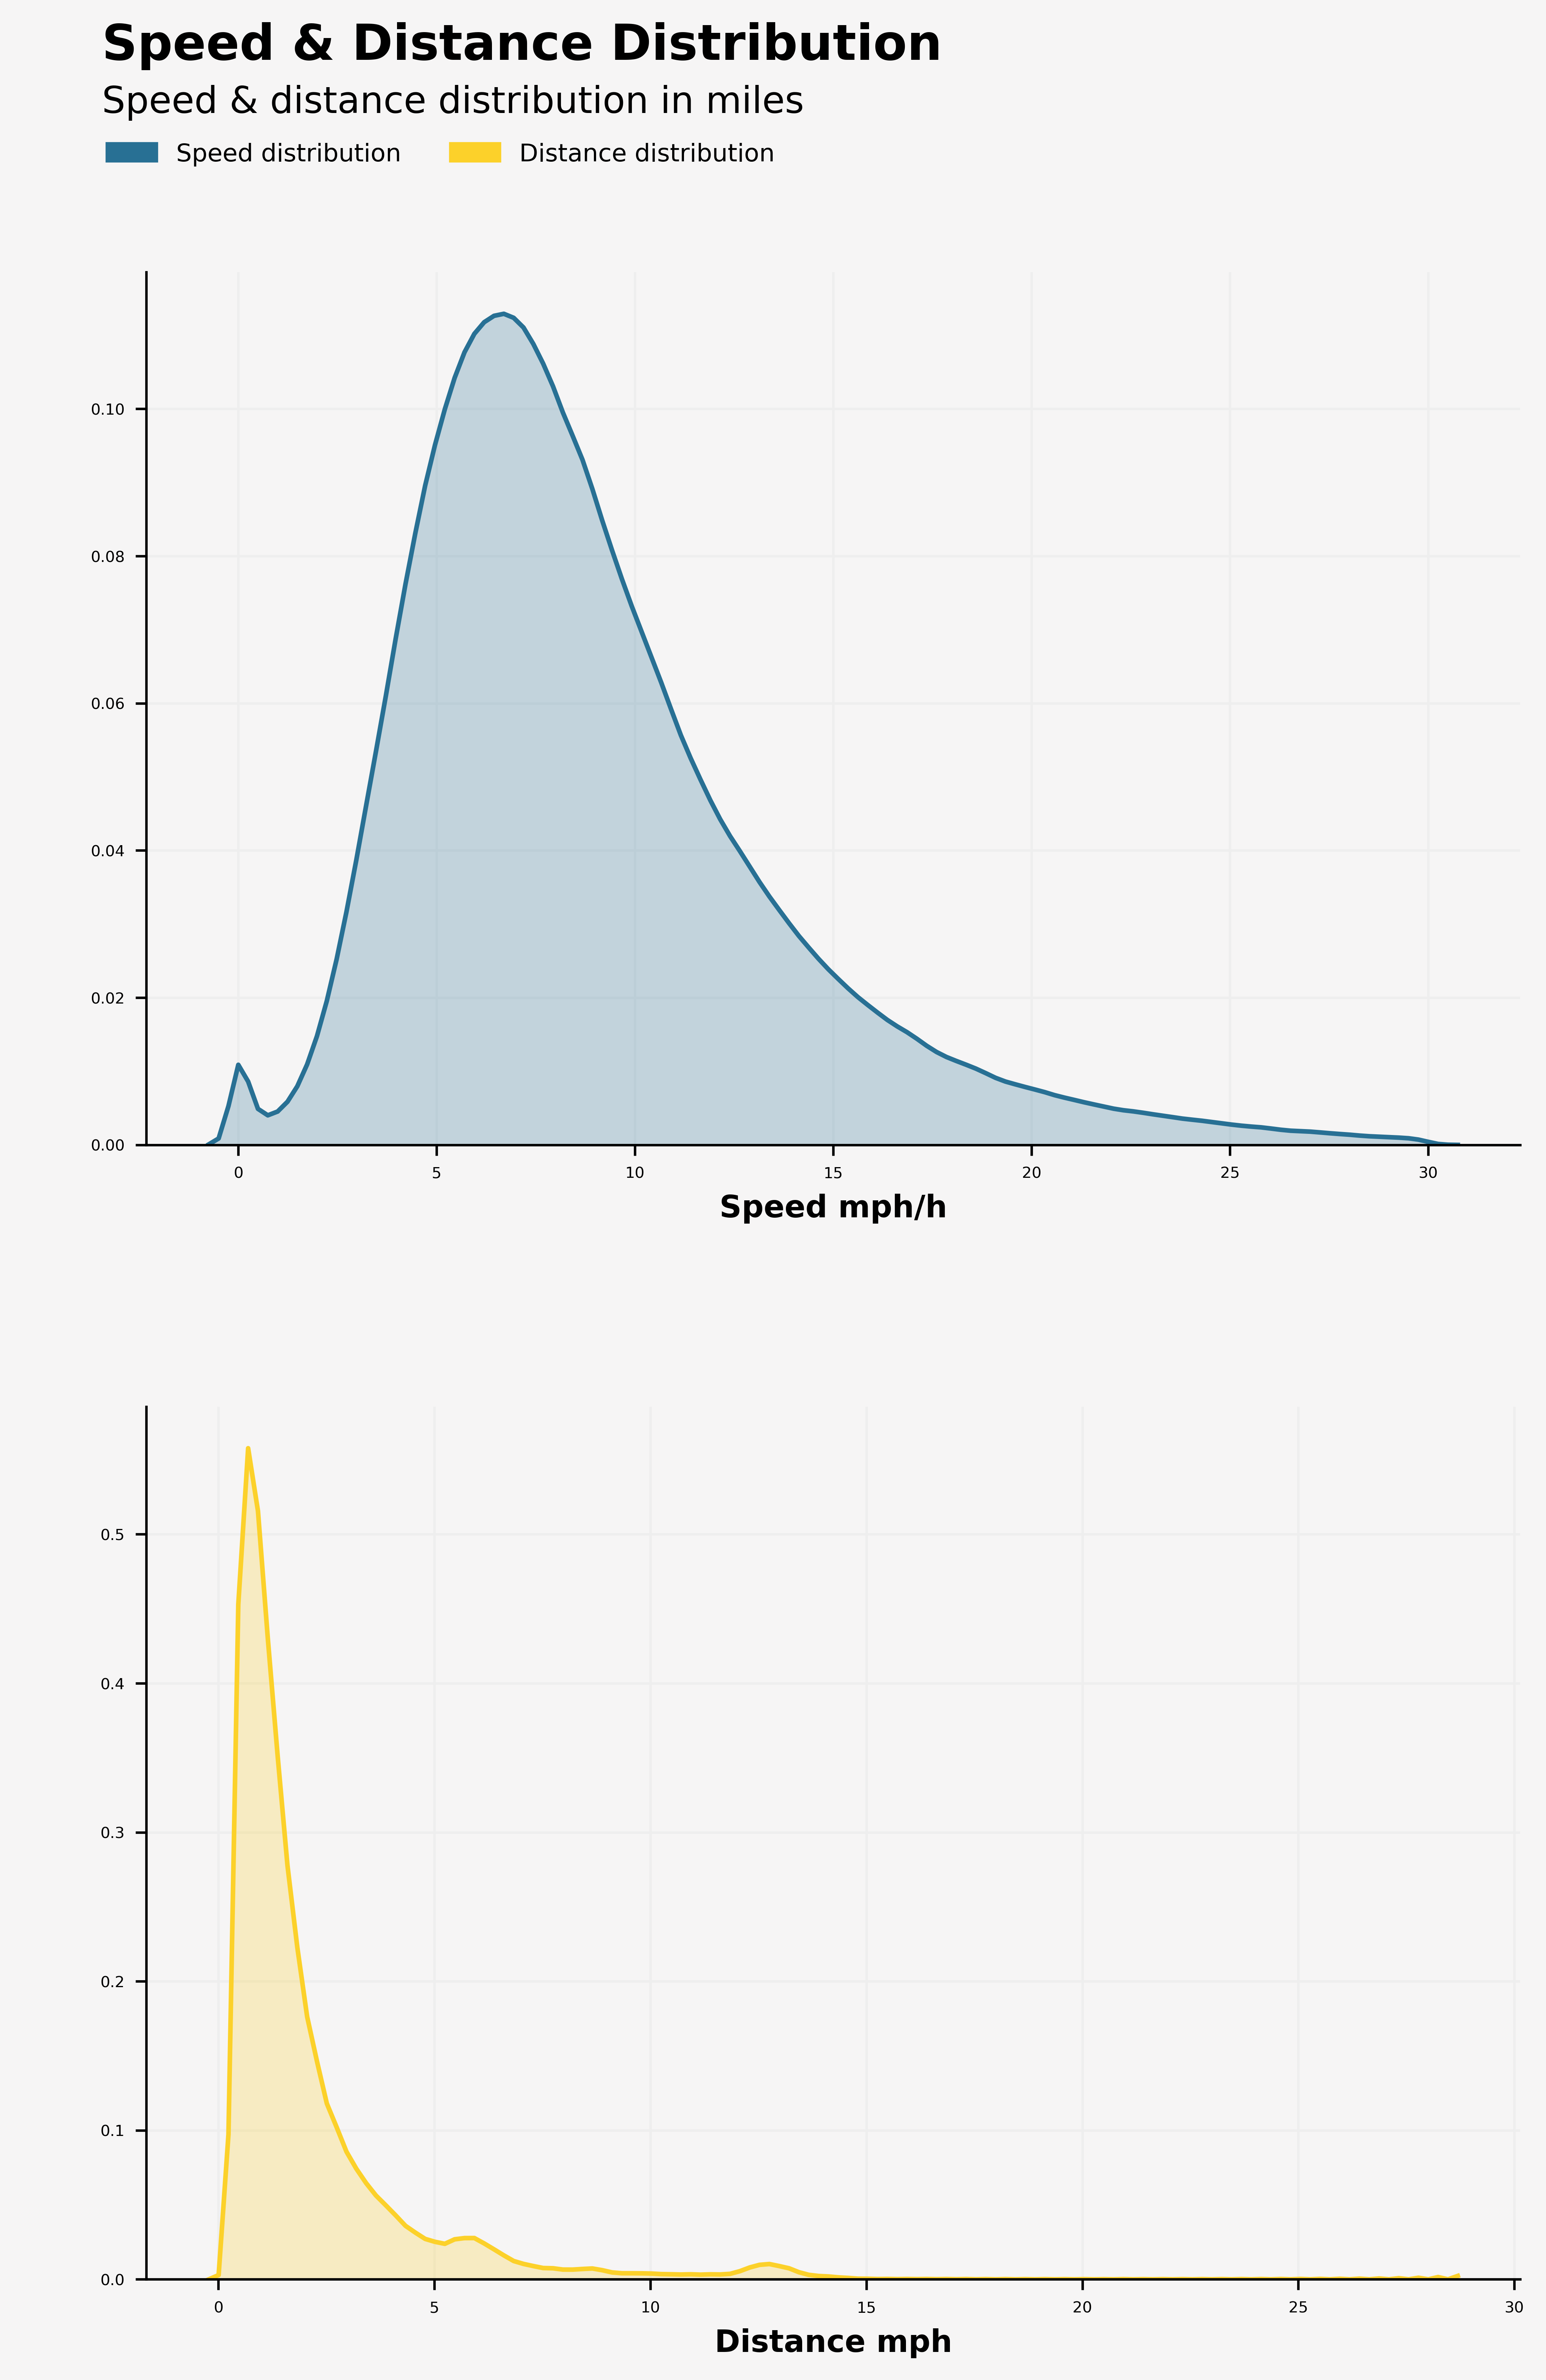

In [10]:
trip_duration_hist = train['trip_duration'].sample(n=10000, replace=True, random_state=123) / 60
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(8, 12), facecolor = '#f6f5f5')
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.6, hspace=0.3)

background_color = "#f6f5f5"
color_map = ['#287094']
sns.set_palette(sns.color_palette(color_map))

ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0_sns = sns.kdeplot(ax=ax0, data = train['speed'].values, zorder=2, shade=True)
ax0_sns.set_xlabel('Speed mph/h', fontsize=10, weight='bold')
ax0_sns.set_ylabel('')
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax0_sns.tick_params(labelsize=5)


color_map = ['#fcd12a']
sns.set_palette(sns.color_palette(color_map))
ax1 = fig.add_subplot(gs[1, 0])
for s in ["right", "top"]:
    ax1.spines[s].set_visible(False)
ax1.set_facecolor(background_color)
ax1_sns = sns.kdeplot(ax=ax1, data = train['distance'].values, zorder=2, shade=True)
ax1_sns.set_xlabel('Distance mph', fontsize=10, weight='bold')
ax1_sns.set_ylabel('')
ax1_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE')
ax1_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE')
ax1_sns.tick_params(labelsize=5)


fig.text(0.1, 0.96, 'Speed & Distance Distribution', fontsize=16, fontweight='bold')
fig.text(0.1, 0.94, 'Speed & distance distribution in miles', fontsize=12)

blue = mpatches.Patch(color='#287094')
yellow = mpatches.Patch(color='#fcd12a')
fig.legend(handles = [blue, yellow], labels =  ['Speed distribution','Distance distribution'], ncol=2, facecolor=background_color, edgecolor=background_color, fontsize=8, loc='upper left', bbox_to_anchor=(0.048, 0.85))

### 4.8 Correlation between Features&Target  <a class="anchor" id="4.8"></a>

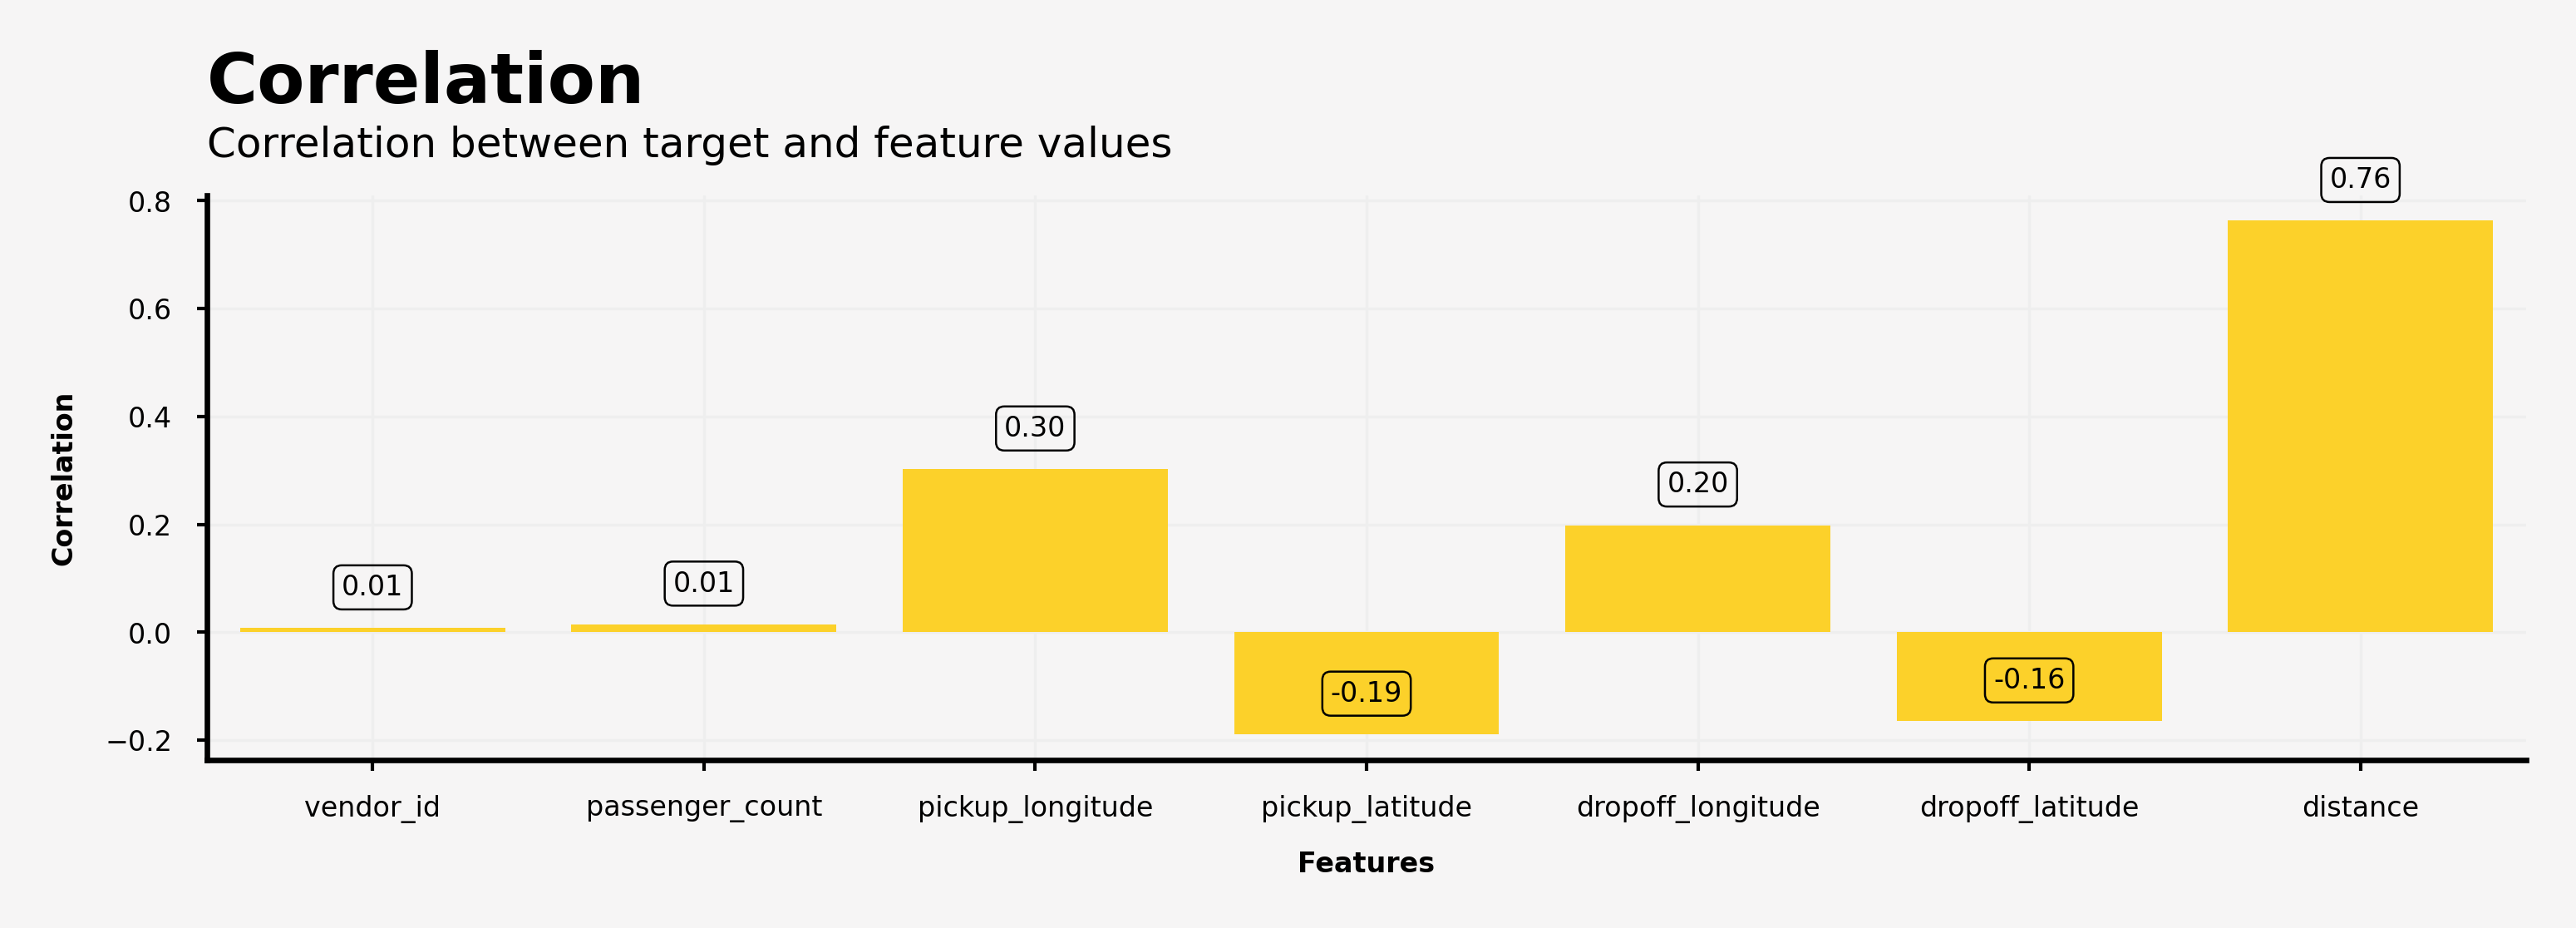

In [11]:
features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude' ,'dropoff_longitude' ,'dropoff_latitude' ,'distance']
chart_df = pd.DataFrame(train[features].corrwith(train['trip_duration']))
chart_df.columns = ['corr']

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(6, 1.5), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.4, hspace=0.1)

background_color = "#f6f5f5"
sns.set_palette(['#00A4CCFF']*6)

ax = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax.spines[s].set_visible(False)
ax.set_facecolor(background_color)
ax_sns = sns.barplot(ax=ax, x=chart_df.index, y=chart_df['corr'], color='#fcd12a',
                      zorder=2, linewidth=0, alpha=1, saturation=1)
ax_sns.set_xlabel("Features",fontsize=4, weight='bold')
ax_sns.set_ylabel("Correlation",fontsize=4, weight='bold')
ax_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.tick_params(labelsize=4, width=0.5, length=1.5)
ax.text(-0.5, 1.08, 'Correlation', fontsize=10, ha='left', va='top', weight='bold')
ax.text(-0.5, 0.94, 'Correlation between target and feature values', fontsize=6, ha='left', va='top')
# data label
for p in ax.patches:
    percentage = f'{p.get_height():.2f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.05
    ax.text(x, y, percentage, ha='center', va='bottom', fontsize=4,
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

plt.show()

## 5 XGBoost  <a class="anchor" id="5"></a>

### 5.1 Feature engeering  <a class="anchor" id="5.1"></a>

In [12]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map(lambda x: 0 if x == 'N' else 1)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map(lambda x: 0 if x == 'N' else 1)
features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance', 'pickup_month', 'pickup_date', 'pickup_hour', 'pickup_minute', 'pickup_day', 'store_and_fwd_flag']
y = np.log(train['trip_duration'].values + 1)
train.drop(["trip_duration"], axis=1, inplace=True)
train.drop(['id'], axis=1, inplace=True)
X = train[features]

In [13]:
X = train[features].values

### 5.2  Cross-validation  <a class="anchor" id="5.2"></a>

In [15]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 144226  144227  144228 ... 1442256 1442257 1442258] TEST: [     0      1      2 ... 144223 144224 144225]
TRAIN: [      0       1       2 ... 1442256 1442257 1442258] TEST: [144226 144227 144228 ... 288449 288450 288451]
TRAIN: [      0       1       2 ... 1442256 1442257 1442258] TEST: [288452 288453 288454 ... 432675 432676 432677]
TRAIN: [      0       1       2 ... 1442256 1442257 1442258] TEST: [432678 432679 432680 ... 576901 576902 576903]
TRAIN: [      0       1       2 ... 1442256 1442257 1442258] TEST: [576904 576905 576906 ... 721127 721128 721129]
TRAIN: [      0       1       2 ... 1442256 1442257 1442258] TEST: [721130 721131 721132 ... 865353 865354 865355]
TRAIN: [      0       1       2 ... 1442256 1442257 1442258] TEST: [ 865356  865357  865358 ... 1009579 1009580 1009581]
TRAIN: [      0       1       2 ... 1442256 1442257 1442258] TEST: [1009582 1009583 1009584 ... 1153805 1153806 1153807]
TRAIN: [      0

### 5.3 Using XGBoost module  <a class="anchor" id="5.3"></a>

In [104]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names = features)
dvalid = xgb.DMatrix(X_test, label=y_test, feature_names = features)
dtest = xgb.DMatrix(test[features].values, feature_names = features)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'} 

In [106]:
model = xgb.train(xgb_pars, dtrain, 240, watchlist, early_stopping_rounds=241,
                  maximize=False, verbose_eval=15)
print('Modeling RMSLE %.5f' % model.best_score)

[21:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.02217	valid-rmse:3.02321
[15]	train-rmse:0.37537	valid-rmse:0.37957
[30]	train-rmse:0.36380	valid-rmse:0.37019
[45]	train-rmse:0.35748	valid-rmse:0.36590
[60]	train-rmse:0.35102	valid-rmse:0.36197
[75]	train-rmse:0.34855	valid-rmse:0.36151
[90]	train-rmse:0.34455	valid-rmse:0.35925
[105]	train-rmse:0.34121	valid-rmse:0.35829
[120]	train-rmse:0.33870	valid-rmse:0.35773
[135]	train-rmse:0.33610	valid-rmse:0.35629
[150]

### 5.4 The submission  <a class="anchor" id="5.4"></a>

In [107]:
ytest = model.predict(dtest)
y_pred = np.exp(ytest) - np.ones(len(ytest))
my_submission = pd.DataFrame({'id': test.id, 'trip_duration': y_pred})
my_submission.to_csv("submission.csv", index=False)

### 5.5 Plot Importance  <a class="anchor" id="5.5"></a>

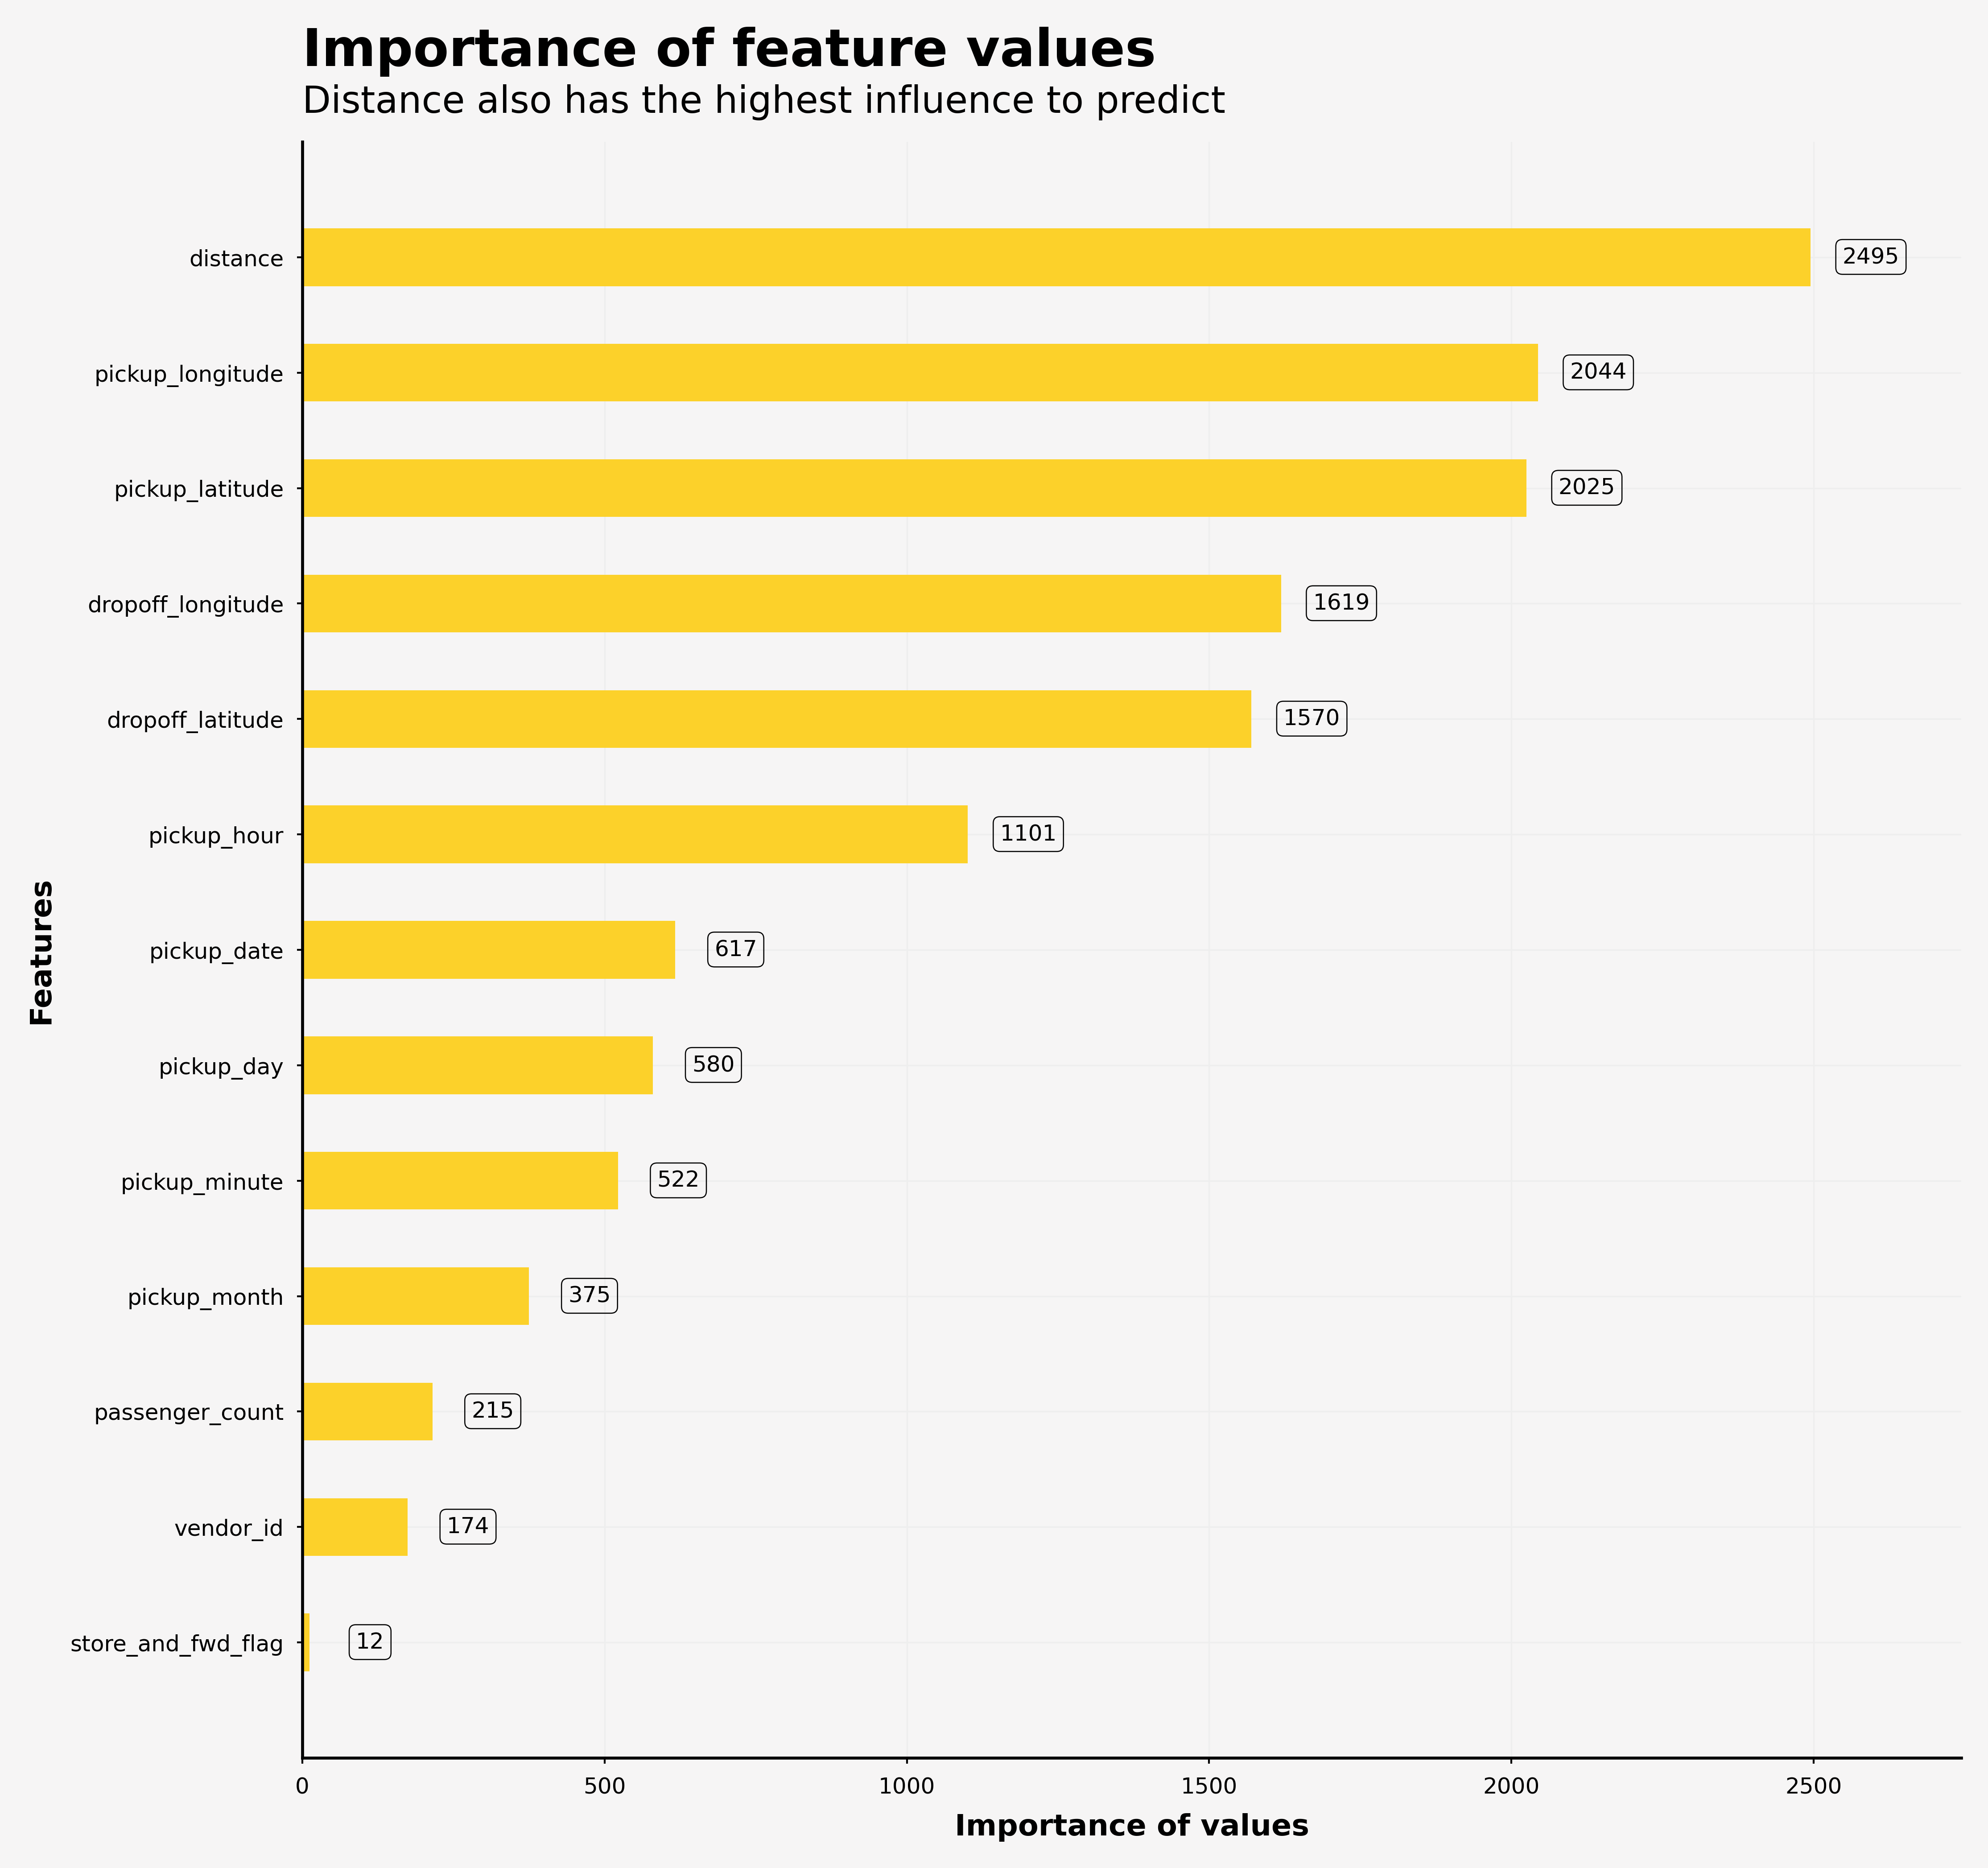

In [111]:
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(8, 8), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.4, hspace=0.3)

background_color = "#f6f5f5"
sns.set_palette(['#00A4CCFF'])

ax = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax.spines[s].set_visible(False)
ax.set_facecolor(background_color)

plot = xgb.plot_importance(model,ax = ax,height =0.5, color='#fcd12a', zorder=2, linewidth=0, show_values = False)
plot.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
plot.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
plot.set_xlabel("Importance of values",fontsize=8, weight='bold')
plot.set_ylabel("Features",fontsize=8, weight='bold')
plot.set_title("")
plot.tick_params(labelsize=6, width=0.5, length=1.5)

ax.text(0, 14, 'Importance of feature values', fontsize=14, ha='left', va='top', weight='bold')
ax.text(0, 13.5, 'Distance also has the highest influence to predict', fontsize=10, ha='left', va='top')

for p in ax.patches:
    percentage = f'{p.get_width():.0f}'
    x = p.get_x() + p.get_width() + 100
    y = p.get_y() + p.get_height() - 0.34
    ax.text(x, y, percentage, ha='center', va='bottom', fontsize=6,
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))
    
plt.show();